In [1]:
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
import lightgbm as lgb
import seaborn as sns

In [2]:
xlsx_file = pd.ExcelFile('./2021-2022_O3&气象五参.xlsx')
sheet_names = xlsx_file.sheet_names
data = pd.DataFrame()

# datat= pd.read_excel('./预测数据.xlsx')
# datat

#得到2021和2022年的数据
df1 = xlsx_file.parse(sheet_names[0])
df2 = xlsx_file.parse(sheet_names[1])
data = pd.concat([df1,df2])
data = data.reset_index(drop=True)
# datat.info()
columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
for column in columns_to_interpolate:
        if column in data.columns:
            data[column] = data[column].interpolate(method='linear')

def daypart(hour):
    if hour in [2,3,4,5]:
        return "dawn"
    elif hour in [6,7,8,9]:
        return "morning"
    elif hour in [10,11,12,13]:
        return "noon"
    elif hour in [14,15,16,17]:
        return "afternoon"
    elif hour in [18,19,20,21]:
        return "evening"
    else: return "midnight"
data['C1705_DATETIME'] = pd.to_datetime(data['C1705_DATETIME'])
data['year'] = data.C1705_DATETIME.dt.year
data['month'] = data.C1705_DATETIME.dt.month
data['day'] = data.C1705_DATETIME.dt.day
data['hour'] = data.C1705_DATETIME.dt.hour
# data['weekday'] = data.C1705_DATETIME.dt.weekday
# data['day_of_Week'] = data.C1705_DATETIME.dt.dayofweek
to_one_hot = data['C1705_DATETIME'].dt.day_name()
# second: one hot encode to 7 columns
days = pd.get_dummies(to_one_hot)
#display data
for column in days.columns:
    data[column] = days[column]
    
raw_dayparts = data['hour'].apply(daypart)
# one hot encoding
dayparts = pd.get_dummies(raw_dayparts)
for column in dayparts.columns:
    data[column] = dayparts[column]


mask = data['O3VAL'] < 0  # 创建一个布尔掩码，表示负值
data.loc[mask, 'O3VAL'] *= -1  # 将负值取反
data_cho = data[data['C0007_PNAME']=='八大关街道']
data2 = data[data['C0007_PNAME']=='北宅街道']
data3 = data[data['C0007_PNAME']=='登州路街道']
data4 = data[data['C0007_PNAME']=='上马街道']
data5 = data[data['C0007_PNAME']=='兴城路街道']

data_cho = data2

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# data_cho['O3VAL'] = scaler.fit_transform(np.array(data_cho['O3VAL'].values.reshape(-1, 1)))
data_cho['QIWENVAL'] = scaler.fit_transform(np.array(data_cho['QIWENVAL'].values.reshape(-1, 1)))
data_cho['FSVAL'] = scaler.fit_transform(np.array(data_cho['FSVAL'].values.reshape(-1, 1)))
data_cho['FXVAL'] = scaler.fit_transform(np.array(data_cho['FXVAL'].values.reshape(-1, 1)))
data_cho['SHIDUVAL'] = scaler.fit_transform(np.array(data_cho['SHIDUVAL'].values.reshape(-1, 1)))
data_cho['YALIVAL'] = scaler.fit_transform(np.array(data_cho['YALIVAL'].values.reshape(-1, 1)))
#data_cho['O3VAL'] = np.sqrt(data1['O3VAL'])
# 创建一个示例时间序列数据
# dates = pd.date_range(start='2021-01-01 00:00:00',end='2022-12-17 23:00:00',freq='H')
# print(data1[data1['C1705_DATETIME'] == '2021-12-31 23:00:00'])
# ts = pd.Series(scaler.fit_transform(data1.loc[0:82703]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates)
'''
dates = pd.date_range(start='2021-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')
ts = pd.Series(data_cho.loc[0:30480]['O3VAL'].values.reshape(-1, 1).flatten(), index=dates)
# 进行STL分解
stl = STL(ts)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
result = stl.fit()

dates1 = pd.date_range(start='2022-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')
ts1 = pd.Series(scaler.fit_transform(data_cho.loc[30480:]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates1)
# 进行STL分解
stl1 = STL(ts1)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
result1 = stl1.fit()

# 获取分解后的趋势、季节性和残差
trend = result.trend.values
seasonal = result.seasonal.values
residual = result.resid.values

trend1 = result1.trend.values
seasonal1 = result1.seasonal.values
residual1 = result1.resid.values

mean_trend = (trend + trend1) / 2
mean_seasonal = (seasonal + seasonal1) / 2
mean_residual = (residual + residual1) / 2
time_dates = pd.date_range(start='2024-04-01 00:00:00',end='2024-6-30 23:00:00',freq='H')

trend_scaled = scaler.fit_transform(np.array(mean_trend.reshape(-1, 1)))[2160:4344]
seasonal_scaled = scaler.fit_transform(np.array(mean_seasonal.reshape(-1, 1)))[2160:4344]
residual_scaled = scaler.fit_transform(np.array(mean_residual.reshape(-1, 1)))[2160:4344]

trend_scaled = np.array(mean_trend.reshape(-1, 1))[2160:4344]
seasonal_scaled = np.array(mean_seasonal.reshape(-1, 1))[2160:4344]
residual_scaled = np.array(mean_residual.reshape(-1, 1))[2160:4344]


trend_array = {}
seasonal_array = {}
residual_array = {}
for i in range(0, 2184):
    trend_array[time_dates[i]] = trend_scaled[i][0]
    seasonal_array[time_dates[i]] = seasonal_scaled[i][0]
    residual_array[time_dates[i]] = residual_scaled[i][0]
'''   

C:\Users\lenovo\AppData\Local\Temp\ipykernel_30056\4246338203.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cho['QIWENVAL'] = scaler.fit_transform(np.array(data_cho['QIWENVAL'].values.reshape(-1, 1)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30056\4246338203.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cho['FSVAL'] = scaler.fit_transform(np.array(data_cho['FSVAL'].values.reshape(-1, 1)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30056\4246338203.py:71: SettingWithCopyWarning:

"\ndates = pd.date_range(start='2021-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')\nts = pd.Series(data_cho.loc[0:30480]['O3VAL'].values.reshape(-1, 1).flatten(), index=dates)\n# 进行STL分解\nstl = STL(ts)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度\nresult = stl.fit()\n\ndates1 = pd.date_range(start='2022-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')\nts1 = pd.Series(scaler.fit_transform(data_cho.loc[30480:]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates1)\n# 进行STL分解\nstl1 = STL(ts1)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度\nresult1 = stl1.fit()\n\n# 获取分解后的趋势、季节性和残差\ntrend = result.trend.values\nseasonal = result.seasonal.values\nresidual = result.resid.values\n\ntrend1 = result1.trend.values\nseasonal1 = result1.seasonal.values\nresidual1 = result1.resid.values\n\nmean_trend = (trend + trend1) / 2\nmean_seasonal = (seasonal + seasonal1) / 2\nmean_residual = (residual + residual1) / 2\ntime_dates = pd.date_range(start='2024-04-01 00:00:00',end='2024-6-30 23:00:00',freq='H')\n\ntr

In [3]:
datat= pd.read_excel('7.30预测.xls')

#datat = datat[datat['C0007_PNAME'] == '八大关街道']
datat = datat[datat['C0007_PNAME'] == '北宅街道']


datat = datat.rename(columns={"TO_CHAR(H.C1705_DATETIME,'YYYY": '日期'})
datat
zhihou = 28*24+1

In [4]:
datat

C0007_SUBSTATION_ID C0007_PNAME             日期  QIWENVAL  FSVAL  \
2149                13763        北宅街道  2024-04-01 00     7.270  1.257   
2150                13763        北宅街道  2024-04-01 01     7.028  0.983   
2151                13763        北宅街道  2024-04-01 02     6.368  0.653   
2152                13763        北宅街道  2024-04-01 03     5.668  0.466   
2153                13763        北宅街道  2024-04-01 04     6.107  0.847   
...                   ...         ...            ...       ...    ...   
4328                13763        北宅街道  2024-06-30 19    26.064  1.016   
4329                13763        北宅街道  2024-06-30 20    24.418  0.748   
4330                13763        北宅街道  2024-06-30 21    23.808  0.898   
4331                13763        北宅街道  2024-06-30 22    23.905  0.815   
4332                13763        北宅街道  2024-06-30 23    23.352  0.488   

        FXVAL  SHIDUVAL   YALIVAL  O3VAL  
2149  279.870    72.805   999.913   90.0  
2150  299.247    75.186   999.947   84.0  
2151  255.998    78.286  1000.043   57.0  
2152  189.529    81.688   999.742   33.0  
2153  289.049    82.825   999.743   58.0  
...       ...       ...       ...    ...  
4328  223.853    72.493   987.620  116.0  
4329  217.114    74.229   988.083  104.0  
4330  308.394    73.700   988.214  100.0  
4331  270.540    74.716   988.772   95.0  
4332      NaN    78.657   989.118   90.0  

[2184 rows x 9 columns]

In [5]:
import os
import pandas as pd
def get_season(month):
    if month in [2, 3, 4]:
        return 1
    elif month in [5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    elif month in [12, 1]:
        return 4
def calculate_wind_speed(U, V):
    return np.sqrt(U**2 + V**2)   

def calculate_wind_direction(U, V):
    # 确保U和V没有缺失值
    U = np.nan_to_num(U)
    V = np.nan_to_num(V)
    direction = np.arctan2(U, V) * (180 / np.pi)  # 转换为角度
    direction = np.mod(direction + 360, 360)  # 确保风向在0到360度之间
    return direction

folder_path = "./wrfout/"
files = os.listdir(folder_path)
columns_to_convert = ['U10', 'V10', '气温开尔文', 'YALIVAL', 'SHIDUVAL']
df_list = []
date_format = "%Y-%m-%d_%H_%M_%S"
for file in files:
    # 获取完整路径
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path, delimiter='\s+', header=None, engine='python',skiprows=1,
                       usecols=[0, 1, 2, 3, 5, 6, 7],
                       names=['日期', '站点', 'U10', 'V10', '气温开尔文', 'YALIVAL', 'SHIDUVAL'])
    
    #data = data[data['站点'] == 'badaguan']
    data = data[data['站点'] == 'beizhai']


    data['year'] = data['日期'].str[:4].astype(int)
    data['month'] = data['日期'].str[5:7].astype(int)
    data['day'] = data['日期'].str[8:10].astype(int)
    data['hour'] = data['日期'].str[11:13].astype(int)
    for column in columns_to_convert:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        data['FSVAL'] = calculate_wind_speed(data['U10'], data['V10'])
        data['FXVAL'] = calculate_wind_direction(data['U10'], data['V10'])
    data['QIWENVAL'] = data['气温开尔文'] - 273.15
    columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
    for column in columns_to_interpolate:
        if column in data.columns:
            data[column] = data[column].interpolate(method='linear')
    data['日期'] = pd.to_datetime(data['日期'], format=date_format)
    df_list.append(data)

def is_weekday_series(series):
    def is_weekday(date):
        weekday = date.weekday()
        return weekday < 5

    return series.apply(is_weekday)

df_list 

[                     日期       站点   U10   V10   气温开尔文  YALIVAL  SHIDUVAL  year  \
 1   2024-05-09 00:00:00  beizhai -2.40  2.38  285.37  1020.42     48.95  2024   
 6   2024-05-09 01:00:00  beizhai -2.03  2.58  284.69  1020.77     58.02  2024   
 11  2024-05-09 02:00:00  beizhai -1.69  2.48  284.20  1020.68     61.90  2024   
 16  2024-05-09 03:00:00  beizhai -0.91  2.38  284.04  1020.76     59.94  2024   
 21  2024-05-09 04:00:00  beizhai -0.96  2.53  283.83  1021.12     58.01  2024   
 ..                  ...      ...   ...   ...     ...      ...       ...   ...   
 936 2024-05-16 19:00:00  beizhai -5.23  6.74  287.53  1018.78     77.92  2024   
 941 2024-05-16 20:00:00  beizhai -5.04  7.28  287.58  1018.78     73.03  2024   
 946 2024-05-16 21:00:00  beizhai -4.08  7.11  287.05  1019.20     78.96  2024   
 951 2024-05-16 22:00:00  beizhai -3.80  7.09  286.64  1019.49     88.54  2024   
 956 2024-05-16 23:00:00  beizhai -4.24  6.58  286.60  1019.59     94.91  2024   
 
      month  d

In [6]:
datat['日期'] = pd.to_datetime(datat['日期'])
datat['year'] = datat.日期.dt.year
datat['month'] = datat.日期.dt.month
datat['day'] = datat.日期.dt.day
datat['hour'] = datat.日期.dt.hour
datat['is_weekday'] = is_weekday_series(datat.日期)
datat['weekday'] = datat.日期.dt.weekday
#datat['O3VAL'] = np.sqrt(datat['O3VAL'])

# datat1['O3_roll_mean_24'] = datat1['O3VAL'].rolling(window=24).mean()
# datat1['O3_roll_max_24'] = datat1['O3VAL'].rolling(window=24).max()
# datat1['O3_roll_min_24'] = datat1['O3VAL'].rolling(window=24).min()


columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
for column in columns_to_interpolate:
    if column in datat.columns:
        datat[column] = datat[column].interpolate(method='linear')


to_one_hot1 = datat['日期'].dt.day_name()
days1 = pd.get_dummies(to_one_hot1)
for column in days1.columns:
    datat[column] = days[column]
    
raw_dayparts = datat['hour'].apply(daypart)
dayparts = pd.get_dummies(raw_dayparts)
for column in dayparts.columns:
    datat[column] = dayparts[column]
datat['Trend'] = 0
datat['Seasonal'] = 0
datat['residual'] = 0

# datat['O3_roll_mean_24'] = datat['O3VAL'].rolling(window=24).mean()
# datat['O3_roll_max_24'] = datat['O3VAL'].rolling(window=24).max()
# datat['O3_roll_min_24'] = datat['O3VAL'].rolling(window=24).min()
num = 0
#for index, row in datat.iterrows():
    
    # if row['日期'].strftime('%Y-%m-%d %H:%M:%S') == '2024-05-09 00:00:00':
    #     num = 1
    # # if row['日期'].strftime('%Y-%m-%d %H:%M:%S') == '2024-05-17 00:00:00':
    # #     num = 0   
    # if num != 0:
    #     if num > 24:
    #         row['O3_roll_mean_24'] = 0
    #         row['O3_roll_max_24'] = 0
    #         row['O3_roll_min_24'] = 0
    #     else:
    #         row['O3_roll_mean_24'] = datat.loc[index-num, 'O3_roll_mean_24']
    #         row['O3_roll_max_24'] = datat.loc[index-num, 'O3_roll_max_24']
    #         row['O3_roll_min_24'] = datat.loc[index-num, 'O3_roll_min_24']
    #     num += 1
    #if row['日期'] in trend_array:
    #    datat.loc[index, 'Trend'] = trend_array[row['日期']]
    #    datat.loc[index, 'Seasonal'] = seasonal_array[row['日期']]
    #    datat.loc[index, 'residual'] = seasonal_array[row['日期']]

In [7]:
def add_columns(df):
    for i in range(1, 28*24+1):  # Loop through 1 to 24
        new_col_name = f"O3VAL_{i}"  # New column name based on index
        df[new_col_name] = df['O3VAL'].shift(i)
    # 结束之后
    # df.dropna(axis=0,
    #       how='any',
    #       subset=None,
    #       inplace=True)
    # for i in range(2, 7*24+1):
    #     old_col_name = f"O3VAL_{i-1}"
    #     cur_col_name = f"O3VAL_{i}"
    #     df[cur_col_name] = df[old_col_name] + df[cur_col_name]

    # sum = 0
    # label_sum = 1
    # for i in range(7*24 + 1, 28*24 + 1):
    #     # 构建列名
    #     col_name = f"WEEK_O3VAL_{label_sum}"
    #     del_col_name = f"O3VAL_{i}"
    #     fur_col_name = f"O3VAL_{i + 1}"
    #     if i == 7 * 24 + 7*24+1 or i == 7 * 24 + 14*24+1 or i == 7 * 24 + 21*24:
    #         del_col_name = f"WEEK_O3VAL_{label_sum -1}"
    #     # 累加本周的值
    #     if fur_col_name in df.columns:
    #         df[fur_col_name] = df[del_col_name] + df[fur_col_name]
    #     else:
    #         df[col_name] = df[del_col_name]
    #     del_col_name = f"O3VAL_{i}"
    #     # 计算累加和
    #     sum += 1
        
    #     # 如果累加到一周 (7 * 24 个时间步)
    #     if sum == 7 * 24:
    #         # 构建新特征列
    #         df[col_name] = df[del_col_name]
    #         # 重置累加器
    #         sum = 0
    #         label_sum += 1
    #     df.drop(del_col_name, axis=1, inplace=True)



# Call the function to add columns
add_columns(datat)
datat.dropna(axis=0,
          how='any',
          subset=None,
          inplace=True)

o3_columns = ['O3VAL_' + str(i) for i in range(1,28*24+1)]
datat['max_O3'] = datat[o3_columns].max(axis=1)
datat['min_O3'] = datat[o3_columns].min(axis=1)
datat['avg_O3'] = datat[o3_columns].mean(axis=1)
datat['median_O3'] = datat[o3_columns].median(axis=1)
datat['stddev_O3'] = datat[o3_columns].std(axis=1)

random_values = np.random.uniform(-10, 10, size=len(datat['O3VAL_1']))
new_values = datat['O3VAL_1'] + random_values
# 确保所有值都大于1
new_values = np.maximum(new_values, 1)
# 更新DataFrame中的值
datat['O3VAL_1'] = new_values


datat

C:\Users\lenovo\AppData\Local\Temp\ipykernel_30056\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30056\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30056\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

C0007_SUBSTATION_ID C0007_PNAME                  日期  QIWENVAL  FSVAL  \
2821                13763        北宅街道 2024-04-29 00:00:00    14.228  0.878   
2822                13763        北宅街道 2024-04-29 01:00:00    14.353  1.192   
2823                13763        北宅街道 2024-04-29 02:00:00    13.274  0.971   
2824                13763        北宅街道 2024-04-29 03:00:00    13.033  0.762   
2825                13763        北宅街道 2024-04-29 04:00:00    11.591  0.538   
...                   ...         ...                 ...       ...    ...   
4328                13763        北宅街道 2024-06-30 19:00:00    26.064  1.016   
4329                13763        北宅街道 2024-06-30 20:00:00    24.418  0.748   
4330                13763        北宅街道 2024-06-30 21:00:00    23.808  0.898   
4331                13763        北宅街道 2024-06-30 22:00:00    23.905  0.815   
4332                13763        北宅街道 2024-06-30 23:00:00    23.352  0.488   

        FXVAL  SHIDUVAL  YALIVAL  O3VAL  year  ...  O3VAL_668  O3VAL_669  \
2821   94.501    69.971  999.874   27.0  2024  ...       58.0       33.0   
2822   97.553    66.041  999.646   35.0  2024  ...       84.0       58.0   
2823  101.723    70.234  999.065   25.0  2024  ...       83.0       84.0   
2824  180.999    65.422  998.326   31.0  2024  ...       23.0       83.0   
2825  161.489    73.365  998.323   18.0  2024  ...       93.0       23.0   
...       ...       ...      ...    ...   ...  ...        ...        ...   
4328  223.853    72.493  987.620  116.0  2024  ...      149.0      169.0   
4329  217.114    74.229  988.083  104.0  2024  ...      146.0      149.0   
4330  308.394    73.700  988.214  100.0  2024  ...      139.0      146.0   
4331  270.540    74.716  988.772   95.0  2024  ...      144.0      139.0   
4332  270.540    78.657  989.118   90.0  2024  ...      197.0      144.0   

      O3VAL_670  O3VAL_671  O3VAL_672  max_O3  min_O3      avg_O3  median_O3  \
2821       57.0       84.0       90.0   227.0     3.0  103.902530      104.0   
2822       33.0       57.0       84.0   227.0     3.0  103.808780      104.0   
2823       58.0       33.0       57.0   227.0     3.0  103.735863      104.0   
2824       84.0       58.0       33.0   227.0     3.0  103.688244      104.0   
2825       83.0       84.0       58.0   227.0     3.0  103.685268      104.0   
...         ...        ...        ...     ...     ...         ...        ...   
4328      167.0      169.0      192.0   274.0     9.0  113.047619      105.0   
4329      169.0      167.0      169.0   274.0     9.0  112.934524      105.0   
4330      149.0      169.0      167.0   274.0     9.0  112.837798      105.0   
4331      146.0      149.0      169.0   274.0     9.0  112.738095      105.0   
4332      139.0      146.0      149.0   274.0     9.0  112.627976      105.0   

      stddev_O3  
2821  33.337297  
2822  33.464791  
2823  33.561261  
2824  33.650256  
2825  33.656605  
...         ...  
4328  44.866335  
4329  44.762690  
4330  44.711558  
4331  44.665279  
4332  44.617558  

[1512 rows x 708 columns]

In [8]:
# Merge the DataFrames on the date
# pd.set_option('display.max_rows', None)  # 取消行数限制
# pd.set_option('display.max_columns', None)  # 取消列数限制
o3_columns = ['O3VAL_' + str(i) for i in range(1,28*24+1)]
day_time_columns = ['dawn','morning','noon','afternoon','evening','midnight']
sta_o3 = ['max_O3','min_O3','avg_O3','median_O3','stddev_O3']
# windows_o3 = ['O3_roll_mean_24','O3_roll_max_24','O3_roll_min_24']
merged_df_list = [] 
X_list = []
y_list = []
for i in range(len(df_list)):
    merged_df = pd.merge_asof(df_list[i], datat[['日期', 'O3VAL','Trend','Seasonal','residual','is_weekday']+o3_columns+day_time_columns+sta_o3], left_on='日期', right_on='日期', direction='nearest')
    # merged_df['O3VAL'] = scaler.fit_transform(np.array(merged_df['O3VAL'].values.reshape(-1, 1)))
    merged_df['QIWENVAL'] = scaler.fit_transform(np.array(merged_df['QIWENVAL'].values.reshape(-1, 1)))
    merged_df['FSVAL'] = scaler.fit_transform(np.array(merged_df['FSVAL'].values.reshape(-1, 1)))
    merged_df['FXVAL'] = scaler.fit_transform(np.array(merged_df['FXVAL'].values.reshape(-1, 1)))
    merged_df['SHIDUVAL'] = scaler.fit_transform(np.array(merged_df['SHIDUVAL'].values.reshape(-1, 1)))
    merged_df['YALIVAL'] = scaler.fit_transform(np.array(merged_df['YALIVAL'].values.reshape(-1, 1)))
    merged_df_list.append(merged_df)
    X = merged_df[['year', 'month', 'day', 'hour', 'is_weekday'] +o3_columns+day_time_columns+['QIWENVAL'	,'FSVAL'	,'SHIDUVAL'	,'YALIVAL']+ sta_o3 ]
    y = merged_df['O3VAL']
    X_list.append(X)
    y_list.append(y)


In [9]:
model = lgb.Booster(model_file='lgb_first_attempt_nor_tre.txt')

In [10]:
X_list[0]

year  month  day  hour  is_weekday     O3VAL_1  O3VAL_2  O3VAL_3  \
0    2024      5    9     0        True  162.391696    168.0    145.0   
1    2024      5    9     1        True  152.310192    155.0    168.0   
2    2024      5    9     2        True  139.502147    158.0    155.0   
3    2024      5    9     3        True  147.910073    148.0    158.0   
4    2024      5    9     4        True  129.717759    142.0    148.0   
..    ...    ...  ...   ...         ...         ...      ...      ...   
187  2024      5   16    19        True  171.861595    178.0    198.0   
188  2024      5   16    20        True  179.300740    178.0    178.0   
189  2024      5   16    21        True  165.401072    175.0    178.0   
190  2024      5   16    22        True  145.783834    162.0    175.0   
191  2024      5   16    23        True  152.776941    155.0    162.0   

     O3VAL_4  O3VAL_5  ...  midnight  QIWENVAL     FSVAL  SHIDUVAL   YALIVAL  \
0      151.0    166.0  ...      True  0.175082  0.340784  0.382859  0.848940   
1      145.0    151.0  ...      True  0.130492  0.329089  0.494229  0.879859   
2      168.0    145.0  ...     False  0.098361  0.295156  0.541871  0.871908   
3      155.0    168.0  ...     False  0.087869  0.240601  0.517805  0.878975   
4      158.0    155.0  ...     False  0.074098  0.259624  0.494106  0.910777   
..       ...      ...  ...       ...       ...       ...       ...       ...   
187    184.0    168.0  ...     False  0.316721  0.961077  0.738581  0.704064   
188    198.0    184.0  ...     False  0.320000  1.000000  0.678536  0.704064   
189    178.0    198.0  ...     False  0.285246  0.920896  0.751351  0.741166   
190    178.0    178.0  ...      True  0.258361  0.902432  0.868983  0.766784   
191    175.0    178.0  ...      True  0.255738  0.876378  0.947200  0.775618   

     max_O3  min_O3      avg_O3  median_O3  stddev_O3  
0     227.0     3.0  106.324405      104.0  35.842131  
1     227.0     3.0  106.376488      104.0  35.891795  
2     227.0     3.0  106.410714      104.0  35.920535  
3     227.0     3.0  106.434524      104.0  35.938837  
4     227.0     3.0  106.441964      104.0  35.943826  
..      ...     ...         ...        ...        ...  
187   245.0     3.0  115.322173      115.0  39.927973  
188   245.0     3.0  115.293899      115.0  39.878873  
189   245.0     3.0  115.289435      115.0  39.873468  
190   245.0     3.0  115.398065      115.0  39.882079  
191   245.0     3.0  115.392113      115.0  39.876906  

[192 rows x 692 columns]

In [11]:
df_list[i].iloc[5] 

日期          2024-06-30 05:00:00
站点                      beizhai
U10                       -1.63
V10                         2.2
气温开尔文                    292.91
YALIVAL                  1000.9
SHIDUVAL                   85.5
year                       2024
month                         6
day                          30
hour                          5
FSVAL                  2.738047
FXVAL                323.464917
QIWENVAL                  19.76
Name: 26, dtype: object

In [12]:
import random

In [13]:
y_pred_list = []
for i in range(len(X_list)):
    y_pred = np.array([])
    X_test = X_list[i].values
    for i, x in enumerate(X_test):
        y_pred = np.append(y_pred, model.predict(x.reshape(1, -1)))
        #y_pred = np.append(y_pred,  np.mean(x[5:7]))
        for j in range(1,min(28*24+1, len(X_test) - i)):  # Loop through 1 to 48
            if 0.1 < random.random() :
                X_test[i+j, 4+j] = y_pred[i] 
    y_pred_list.append(y_pred)
    
    # y_pred = np.append(y_pred, model.predict(x.reshape(1, -1)))
    # old_sum = 0
    # if i != 0:
    #     if i < 7 * 24 + 5:
    #         old_sum = X_test[i, i-1]
    #     else:
    #         old_sum = X_test[7 * 24 + 5, 7 * 24 + 4]
    # for j in range(1, 7*24+1):
    #     if i + j < 8 * 24:
    #         if j == 1:
    #             X_test[i+j, 4+j] = y_pred[i]
    #         else:
    #             X_test[i+j, 4+j] = X_test[i+j, 4+j] - old_sum + y_pred[i]
    # for j in range(3):
    #     if i + j < 8 * 24:
    #         X_test[i+j, 173 +j] = X_test[i+j, 173 +j] - old_sum +  y_pred[i]

    
    

    # for j in range(1,min(171, len(X_test) - i)): # Loop through 1 to 48
    #     X_test[i+j, 4+j] = y_pred[i] 


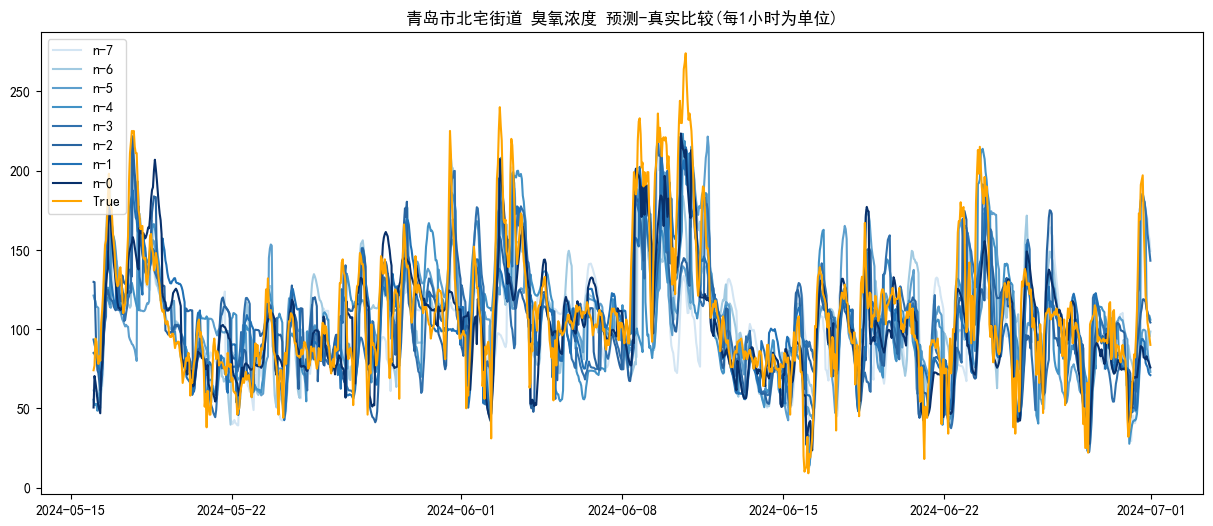

n-7 MASE: 35.06838347280453
n-7 R2: 0.3084936829961713
n-6 MASE: 31.714604955881722
n-6 R2: 0.4344340299907897
n-5 MASE: 35.076732594752244
n-5 R2: 0.3081643745266154
n-4 MASE: 32.67208480795943
n-4 R2: 0.39976909422457885
n-3 MASE: 29.735242851288305
n-3 R2: 0.502826883029054
n-2 MASE: 32.31582052288436
n-2 R2: 0.41278785013096375
n-1 MASE: 28.40770455136521
n-1 R2: 0.5462287849130334
n-0 MASE: 28.30471244678478
n-0 R2: 0.5495131146113355


In [14]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.dates as mdates
from datetime import datetime, timedelta
date_range_list = []
start_date111 = datetime(2024, 5, 16, 0, 0, 0) 
end_date111 = datetime(2024, 6, 30, 23, 0, 0)
true_value_list = []
date_range111 = pd.date_range(start=start_date111, end=end_date111, freq='H')
merged_data = pd.merge(pd.DataFrame(date_range111, columns=['日期']), datat, on='日期', how='inner')

true_value_list = merged_data['O3VAL'].tolist()

start_date = datetime(2024, 5, 16, 0, 0, 0) 
end_date = datetime(2024, 5, 16, 23, 0, 0)
while end_date < datetime(2024, 7, 1, 0, 0, 0):
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    date_range_list.append(date_range)
    end_date += timedelta(hours=1)
    start_date = end_date
    end_date += timedelta(days=1)
    end_date -= timedelta(hours=1)

num = 0
colors = [
 '#d3e5f3','#a1cae1', 
    '#5d9fcd', '#4292c6',  '#3171ad',
    '#2864a0', '#2171b5',   '#08306b','orange'
]
true_legend_added = 0 
pred_value_list_7 = np.array([])
pred_value_list_6 = np.array([])
pred_value_list_5 = np.array([])
pred_value_list_4 = np.array([])
pred_value_list_3 = np.array([])
pred_value_list_2 = np.array([])
pred_value_list_1 = np.array([])
pred_value_list_0 = np.array([])

for date_ranges in date_range_list:
    num = 7
    for i in range(len(df_list)):
        is_in_list = df_list[i]['日期'].isin(date_ranges)
        rmse_list = []
        r2_list = []
        if is_in_list.any():
            matching_indices = df_list[i].index[is_in_list].tolist()
            matching_values = df_list[i].loc[is_in_list, '日期'].tolist()
            if num == 7:
                pred_value_list_7 = np.concatenate((pred_value_list_7, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 6:
                pred_value_list_6 = np.concatenate((pred_value_list_6, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 5:
                pred_value_list_5 = np.concatenate((pred_value_list_5, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 4:
                pred_value_list_4 = np.concatenate((pred_value_list_4, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 3:
                pred_value_list_3 = np.concatenate((pred_value_list_3, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 2:
                pred_value_list_2 = np.concatenate((pred_value_list_2, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 1:
                pred_value_list_1 = np.concatenate((pred_value_list_1, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 0:
                pred_value_list_0 = np.concatenate((pred_value_list_0, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            num-=1



plt.figure(figsize=(15, 6))
plt.title("青岛市北宅街道 臭氧浓度 预测-真实比较(每1小时为单位)")
plt.plot(date_range111,pred_value_list_7,color=colors[0], label='n-7')
plt.plot(date_range111,pred_value_list_6,color=colors[1], label='n-6')
plt.plot(date_range111,pred_value_list_5,color=colors[2], label='n-5')
plt.plot(date_range111,pred_value_list_4,color=colors[3], label='n-4')
plt.plot(date_range111,pred_value_list_3,color=colors[4], label='n-3')
plt.plot(date_range111,pred_value_list_2,color=colors[5], label='n-2')
plt.plot(date_range111,pred_value_list_1,color=colors[6], label='n-1')
plt.plot(date_range111,pred_value_list_0,color=colors[7], label='n-0')
plt.plot(date_range111,true_value_list,color=colors[-1], label='True')
plt.legend()
plt.show()   


print('n-7 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_7)))
print('n-7 R2:',r2_score(true_value_list, pred_value_list_7))
print('n-6 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_6)))
print('n-6 R2:',r2_score(true_value_list, pred_value_list_6))
print('n-5 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_5)))
print('n-5 R2:',r2_score(true_value_list, pred_value_list_5))
print('n-4 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_4)))
print('n-4 R2:',r2_score(true_value_list, pred_value_list_4))
print('n-3 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_3)))
print('n-3 R2:',r2_score(true_value_list, pred_value_list_3))
print('n-2 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_2)))
print('n-2 R2:',r2_score(true_value_list, pred_value_list_2))
print('n-1 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_1)))
print('n-1 R2:',r2_score(true_value_list, pred_value_list_1))
print('n-0 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_0)))
print('n-0 R2:',r2_score(true_value_list, pred_value_list_0))
# r2_list.append(r2_score(y_list[i].values[int(matching_indices[0]/5):int(matching_indices[(j+1)*24-1]/5)+1], y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[(j+1)*24-1]/5)+1]))
# print(f"第{num}条线,前{j+1}天 rmse:", rmse_list[j])
# print(f"第{num}条线,前{j+1}天 r2 score:", r2_list[j])

In [19]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

rmse_list = []
r2_list = []

for i in range(46):
    mase7 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_7[i*24:i*24+24]))
    mase6 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_6[i*24:i*24+24]))
    mase5 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_5[i*24:i*24+24]))
    mase4 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_4[i*24:i*24+24]))
    mase3 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_3[i*24:i*24+24]))
    mase2 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_2[i*24:i*24+24]))
    mase1 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_1[i*24:i*24+24]))
    mase0 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_0[i*24:i*24+24]))
    r27 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_7[i*24:i*24+24])
    r26 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_6[i*24:i*24+24])
    r25 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_5[i*24:i*24+24])
    r24 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_4[i*24:i*24+24])
    r23 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_3[i*24:i*24+24])
    r22 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_2[i*24:i*24+24])
    r21 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_1[i*24:i*24+24])
    r20 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_0[i*24:i*24+24])
    rmse_list.append(mase7)
    rmse_list.append(mase6)
    rmse_list.append(mase5)
    rmse_list.append(mase4)
    rmse_list.append(mase3)
    rmse_list.append(mase2)
    rmse_list.append(mase1)
    rmse_list.append(mase0)
    std_dev1 = np.std(rmse_list)
    r2_list.append(r27)
    r2_list.append(r26)
    r2_list.append(r25)
    r2_list.append(r24)
    r2_list.append(r23)
    r2_list.append(r22)
    r2_list.append(r21)
    r2_list.append(r20)
    std_dev2 = np.std(r2_list)
    col_name1 = 'rmse'
    col_name2 = 'r2'

df = pd.DataFrame({
    'rmse': rmse_list,
    'r2': r2_list
})

# 将 DataFrame 写入 CSV 文件
df.to_csv('metrics_beizhai.csv', index=False)

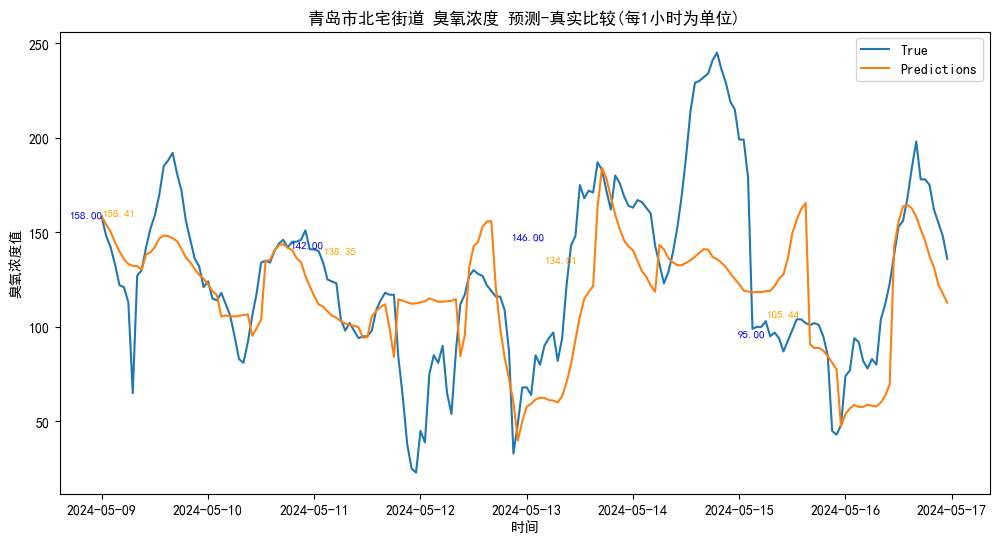

rmse: 37.98559088645588
r2 score: 0.30363041162101334
all
rmse: 37.98559088645588
r2 score: 0.30363041162101334
all-1
rmse: 38.8353607005318
r2 score: 0.2960940635710593
all-2
rmse: 29.830830288115084
r2 score: 0.3799687912845521


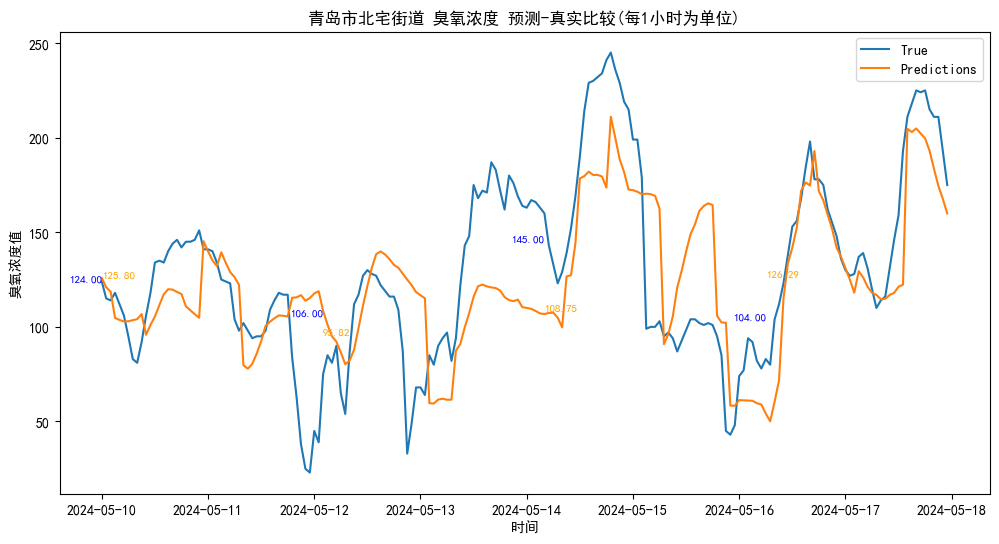

rmse: 35.63338125182648
r2 score: 0.4565102062271267
all
rmse: 35.63338125182648
r2 score: 0.4565102062271267
all-1
rmse: 39.165838378216286
r2 score: 0.33113206844405363
all-2
rmse: 37.920445022392514
r2 score: 0.39055217346590954


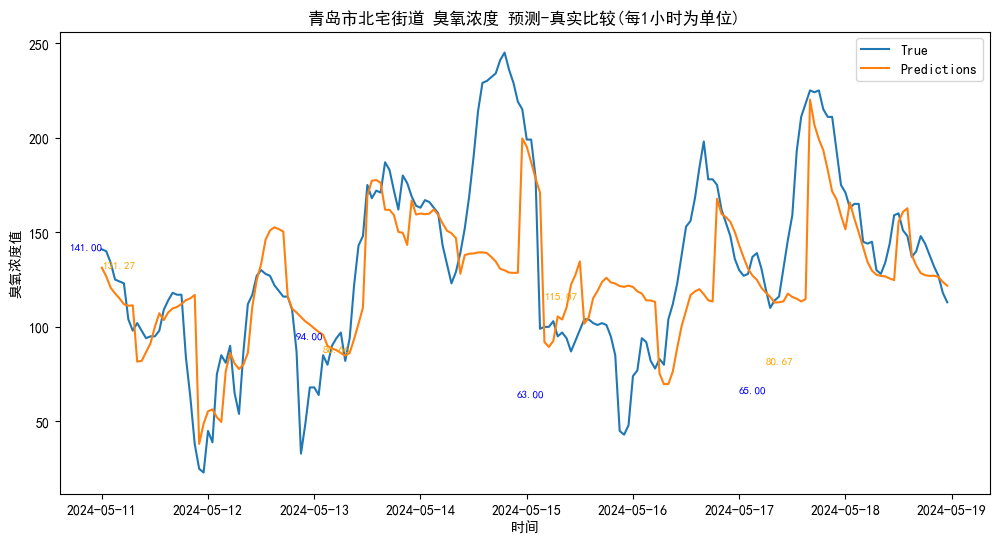

rmse: 36.02444691446942
r2 score: 0.44122378292839837
all
rmse: 36.02444691446942
r2 score: 0.44122378292839837
all-1
rmse: 38.23905149255273
r2 score: 0.41341794059997494
all-2
rmse: 37.96687401036354
r2 score: 0.45883185855664477


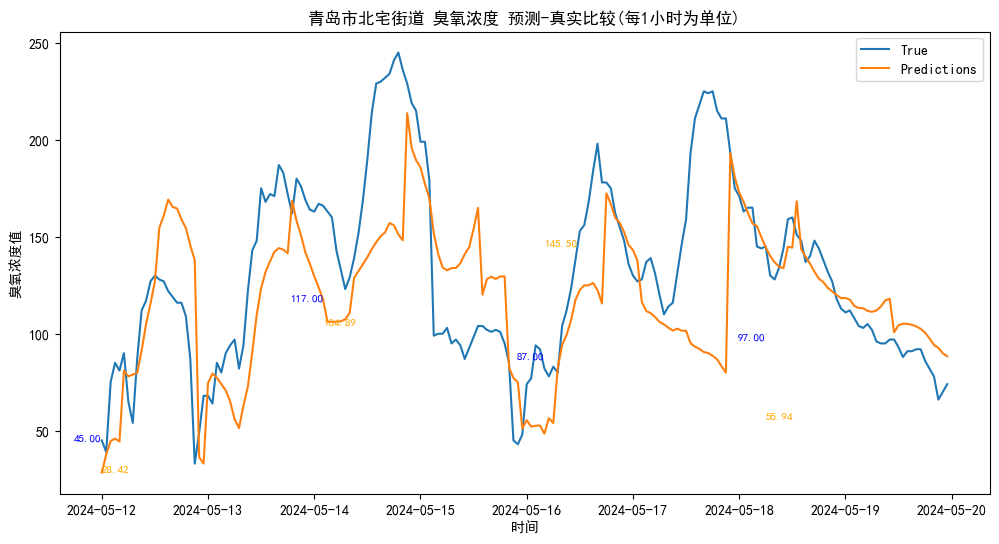

rmse: 42.57018090576085
r2 score: 0.20140832925685803
all
rmse: 42.57018090576085
r2 score: 0.20140832925685803
all-1
rmse: 48.64561734638996
r2 score: 0.11494975714630751
all-2
rmse: 39.575187370391724
r2 score: 0.40514600236051135


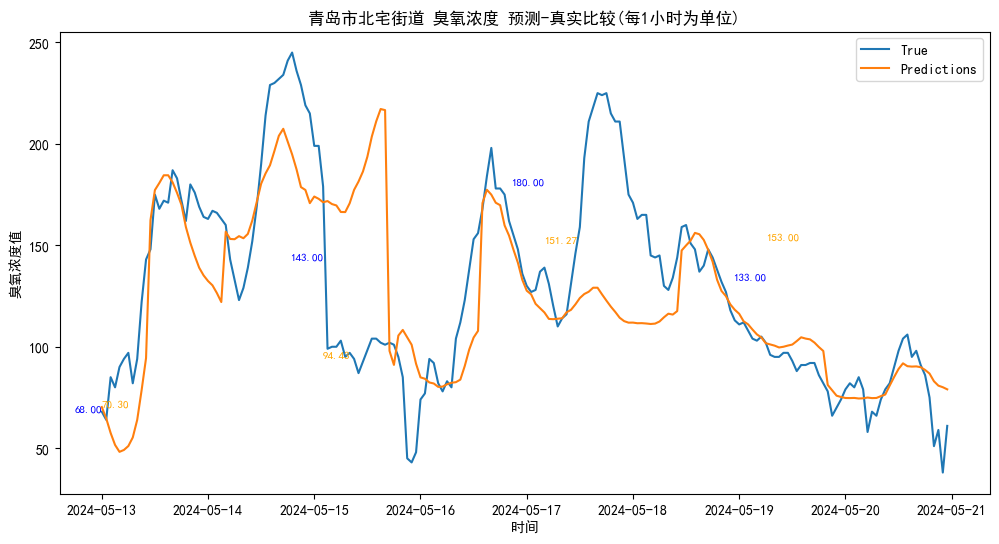

rmse: 38.83164060527675
r2 score: 0.35193077478148627
all
rmse: 38.83164060527675
r2 score: 0.35193077478148627
all-1
rmse: 44.32028864360889
r2 score: 0.0864116981192512
all-2
rmse: 47.03280756608786
r2 score: 0.1277758862870242


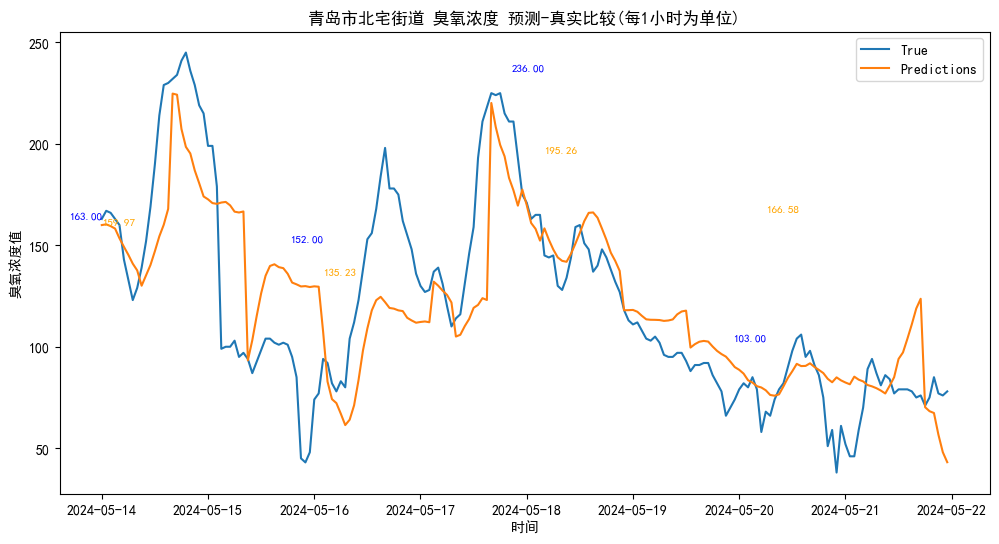

rmse: 31.765710147157264
r2 score: 0.5856821917327317
all
rmse: 31.765710147157264
r2 score: 0.5856821917327317
all-1
rmse: 34.72083692644492
r2 score: 0.4651873993001443
all-2
rmse: 37.38651103476337
r2 score: 0.364408692667622


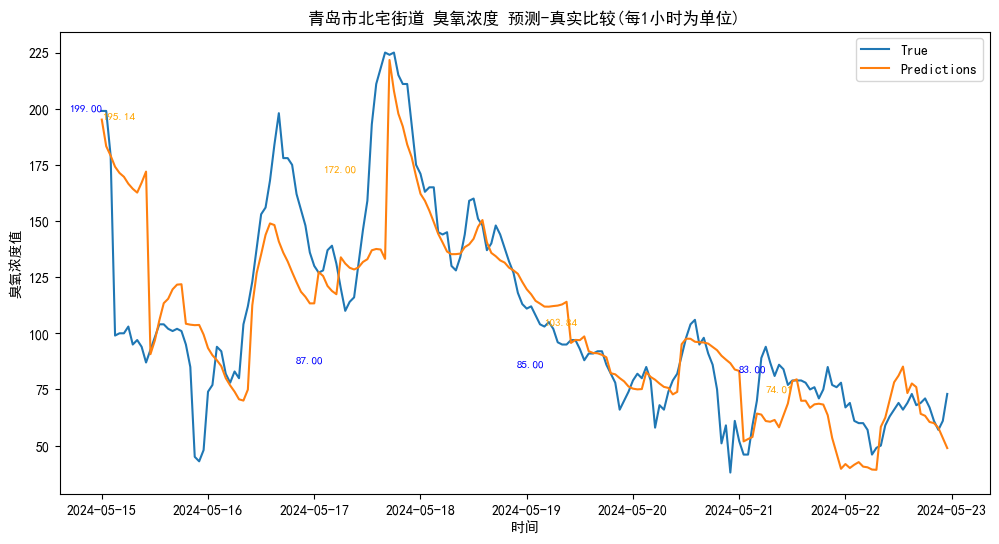

rmse: 25.52719779861458
r2 score: 0.6538048659140345
all
rmse: 25.52719779861458
r2 score: 0.6538048659140345
all-1
rmse: 27.842566233284824
r2 score: 0.5775862058640395
all-2
rmse: 29.573782006532014
r2 score: 0.5005292496148002


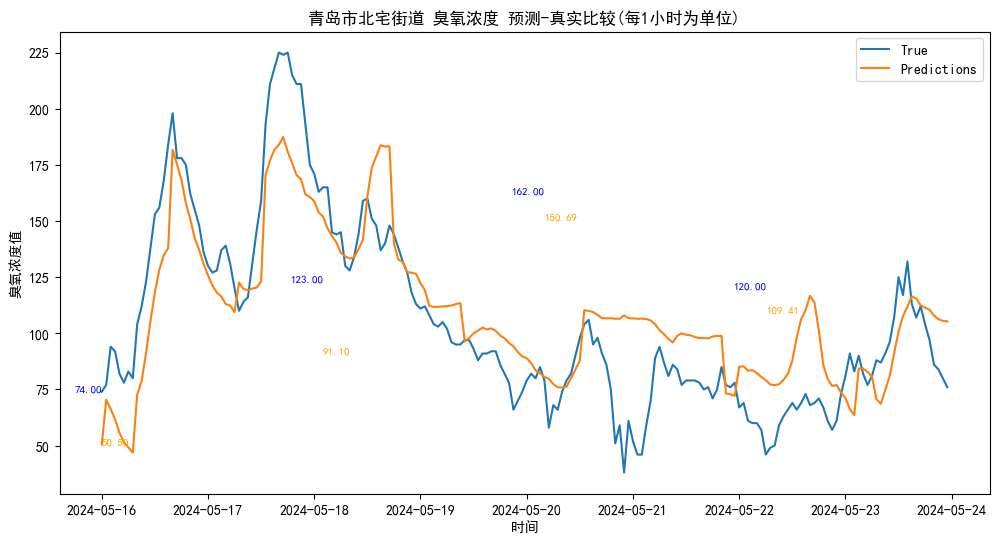

rmse: 23.42231513794749
r2 score: 0.6851058511473862
all
rmse: 23.42231513794749
r2 score: 0.6851058511473862
all-1
rmse: 23.852043554321533
r2 score: 0.6967098614865697
all-2
rmse: 22.798657215305976
r2 score: 0.7185821066634216


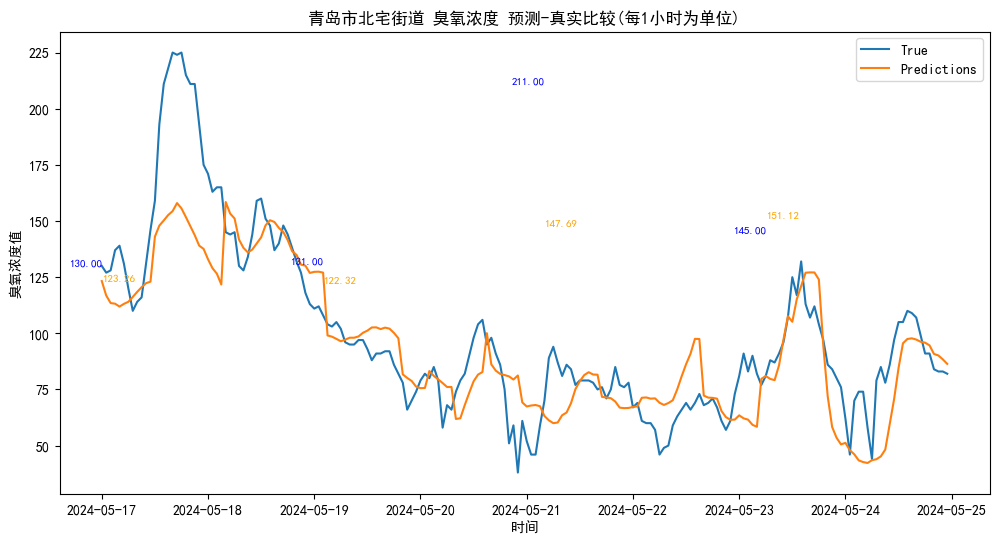

rmse: 21.345602865839957
r2 score: 0.7029956520776426
all
rmse: 21.345602865839957
r2 score: 0.7029956520776426
all-1
rmse: 22.240643616883723
r2 score: 0.738480898443141
all-2
rmse: 23.518951359505053
r2 score: 0.704315942953567


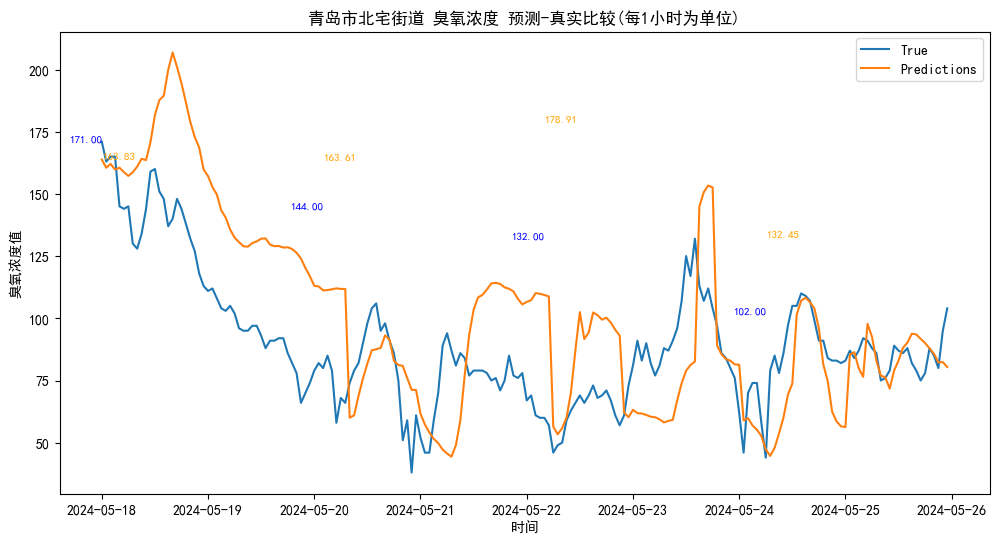

rmse: 29.445760672364397
r2 score: -0.2545157971757508
all
rmse: 29.445760672364397
r2 score: -0.2545157971757508
all-1
rmse: 32.79809814393224
r2 score: -0.2702615288166885
all-2
rmse: 33.37558607520083
r2 score: -0.15454079863144488


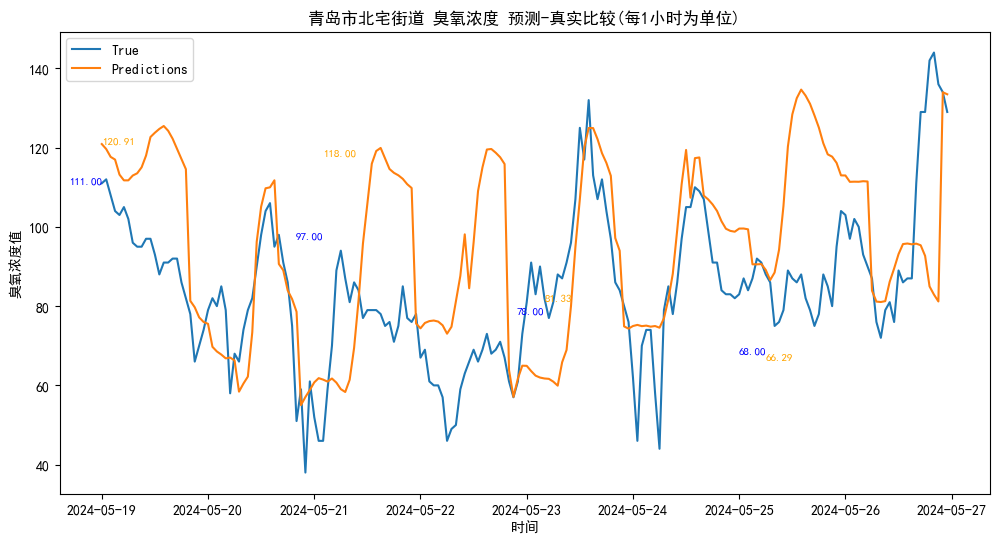

rmse: 23.508844017963963
r2 score: -0.5505834969646028
all
rmse: 23.508844017963963
r2 score: -0.5505834969646028
all-1
rmse: 21.740803433047304
r2 score: -0.4859169215426329
all-2
rmse: 22.986133284466103
r2 score: -0.6768087585410762


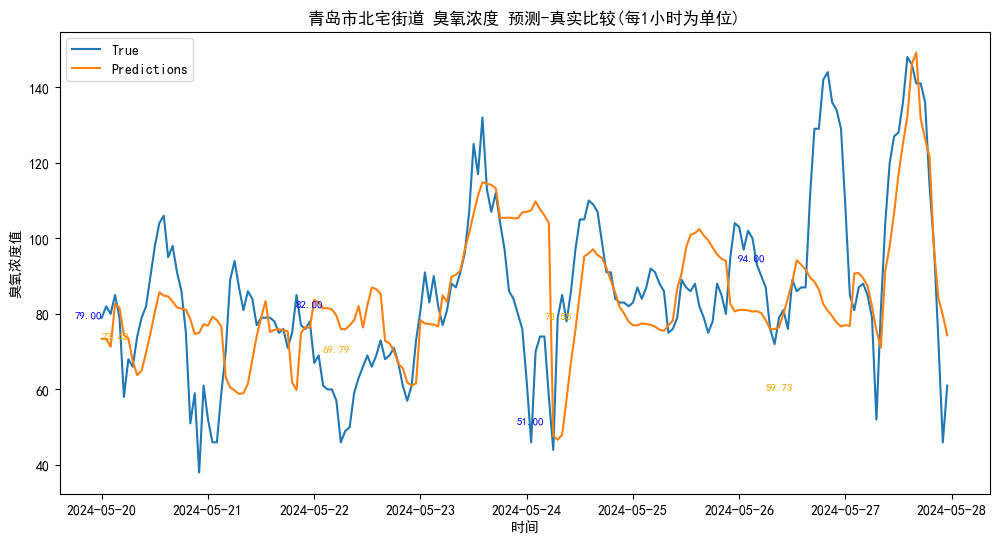

rmse: 19.437991751795682
r2 score: 0.21818388043069104
all
rmse: 19.437991751795682
r2 score: 0.21818388043069104
all-1
rmse: 17.64529005680876
r2 score: -0.11152737782357902
all-2
rmse: 18.341472915389204
r2 score: -0.04749043842594691


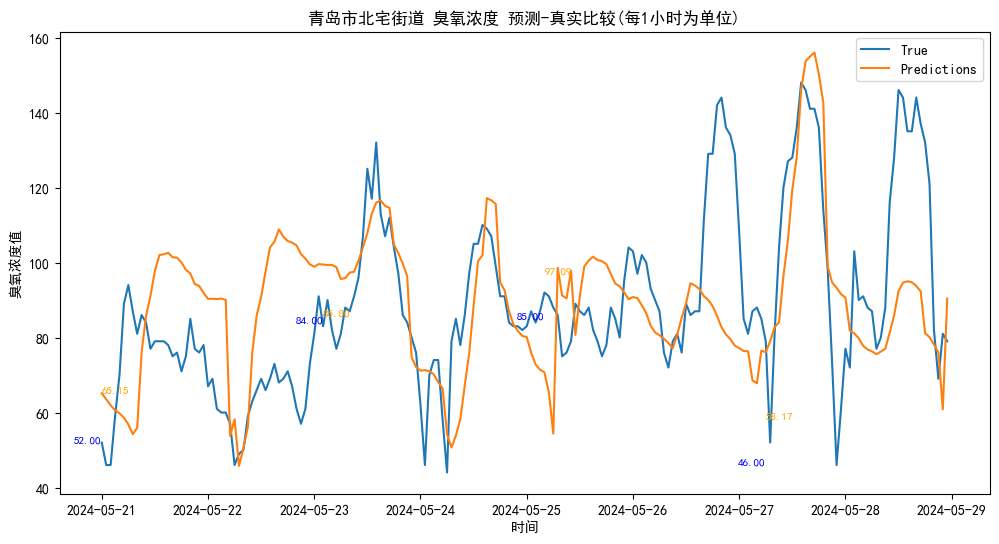

rmse: 22.503631152178688
r2 score: 0.100002148617093
all
rmse: 22.503631152178688
r2 score: 0.100002148617093
all-1
rmse: 21.351865226435745
r2 score: -0.1772864881808367
all-2
rmse: 19.46920565793314
r2 score: -0.3532830198939061


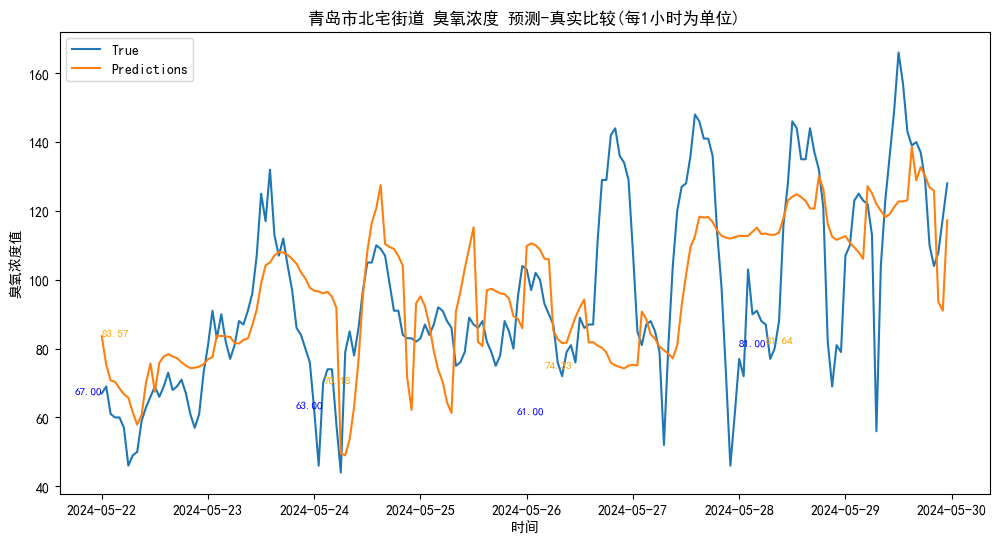

rmse: 22.551447074041874
r2 score: 0.26555087697934654
all
rmse: 22.551447074041874
r2 score: 0.26555087697934654
all-1
rmse: 22.035504804498682
r2 score: 0.09463757650617421
all-2
rmse: 20.58454612742002
r2 score: -0.021747049653461525


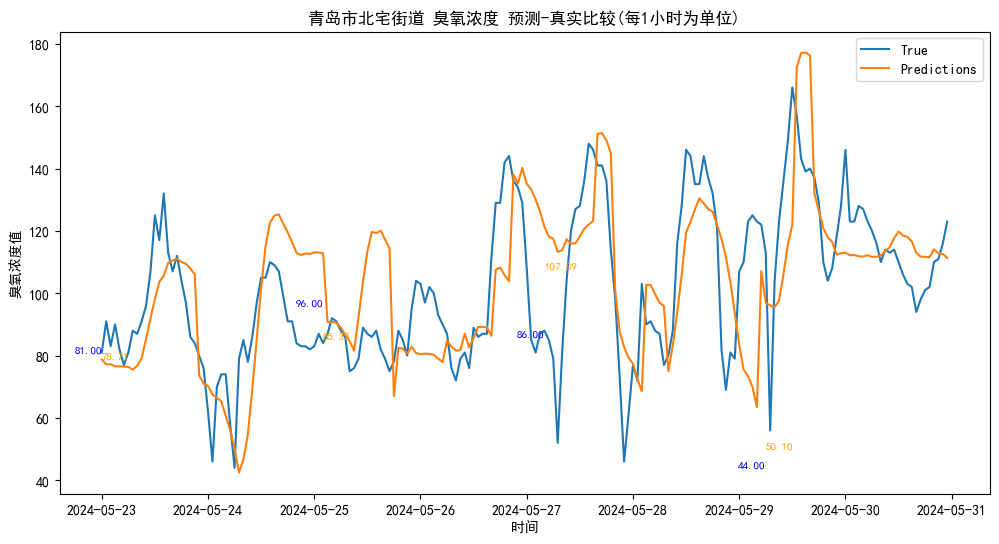

rmse: 21.41412268523412
r2 score: 0.20638153418865357
all
rmse: 21.41412268523412
r2 score: 0.20638153418865357
all-1
rmse: 20.751024281295923
r2 score: 0.18385544156103184
all-2
rmse: 21.114672485377902
r2 score: 0.06043253619558242


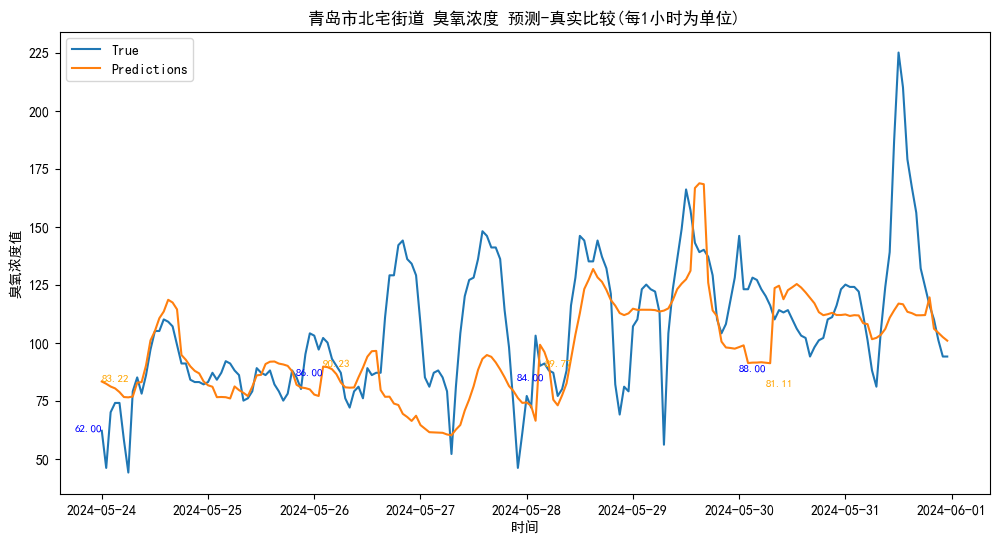

rmse: 27.083316281215165
r2 score: 0.09015379447426031
all
rmse: 27.083316281215165
r2 score: 0.09015379447426031
all-1
rmse: 25.086104987146232
r2 score: 0.0686024463210192
all-2
rmse: 25.783164307095376
r2 score: -0.1355722432611126


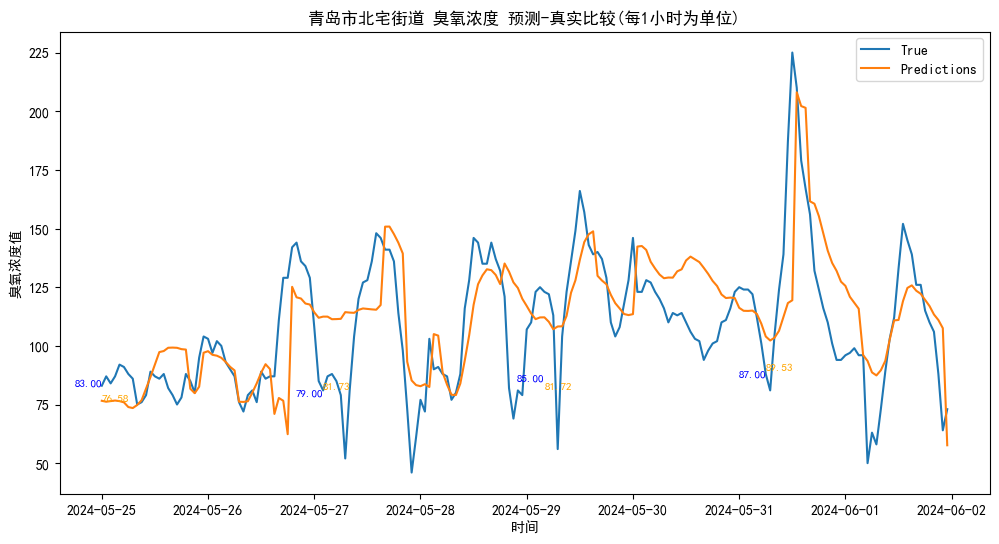

rmse: 22.896048230413896
r2 score: 0.3406139313142119
all
rmse: 22.896048230413896
r2 score: 0.3406139313142119
all-1
rmse: 20.84214357439756
r2 score: 0.2762052260083424
all-2
rmse: 20.555324250454426
r2 score: 0.3757891997091467


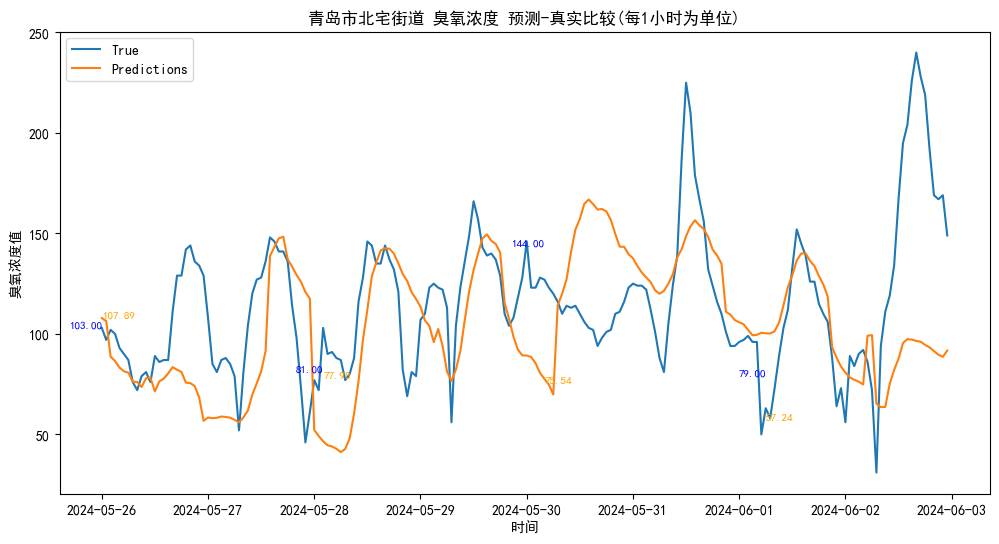

rmse: 40.68151488132742
r2 score: -0.3191893128566887
all
rmse: 40.68151488132742
r2 score: -0.3191893128566887
all-1
rmse: 34.204404764111295
r2 score: -0.4496797997079365
all-2
rmse: 35.410756209892845
r2 score: -1.043687990458786


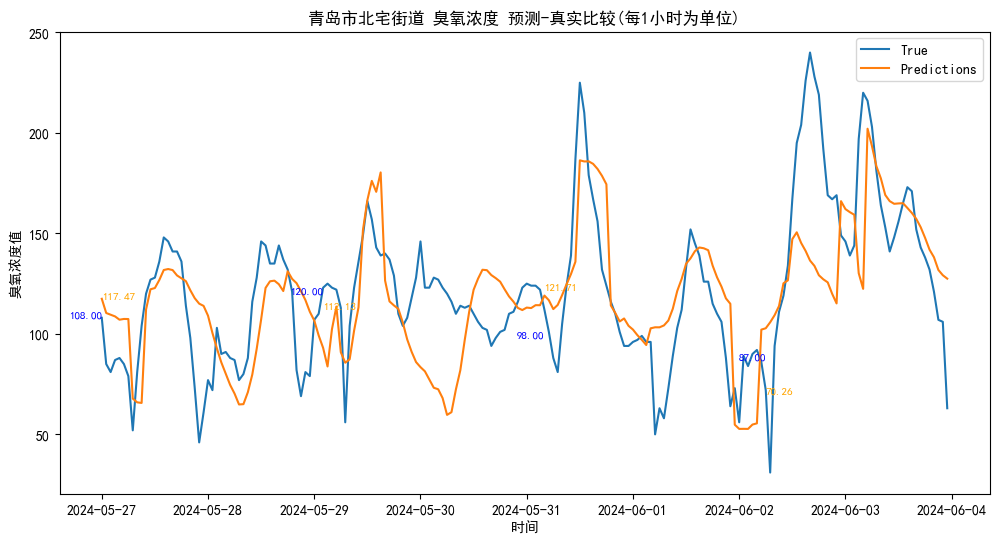

rmse: 31.555640411413723
r2 score: 0.32150386081788396
all
rmse: 31.555640411413723
r2 score: 0.32150386081788396
all-1
rmse: 26.90518450441898
r2 score: 0.15168913322180833
all-2
rmse: 27.344162624729105
r2 score: 0.10847230284112519


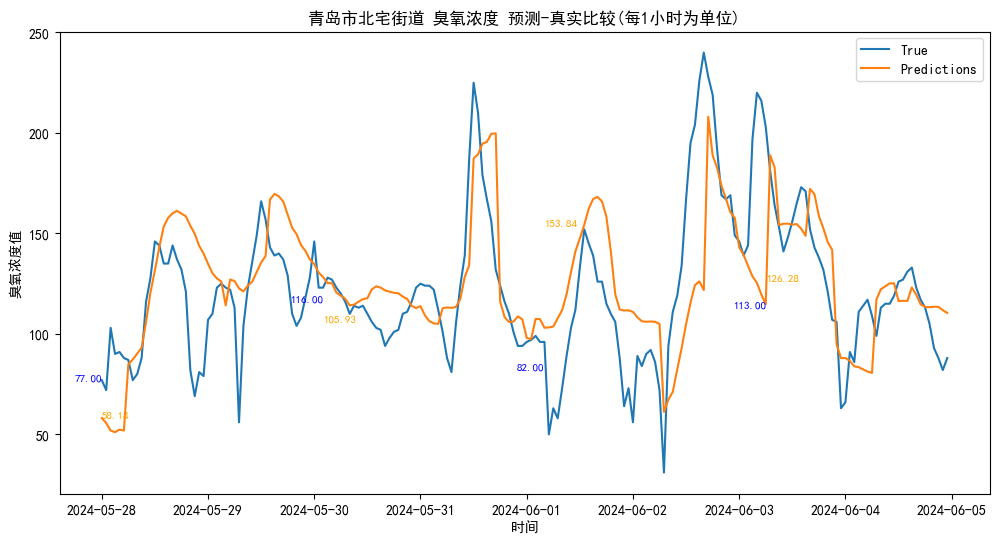

rmse: 31.557708543913886
r2 score: 0.27308259750274744
all
rmse: 31.557708543913886
r2 score: 0.27308259750274744
all-1
rmse: 31.85778974789398
r2 score: 0.25809652375218073
all-2
rmse: 27.69013095206018
r2 score: 0.06358025053777061


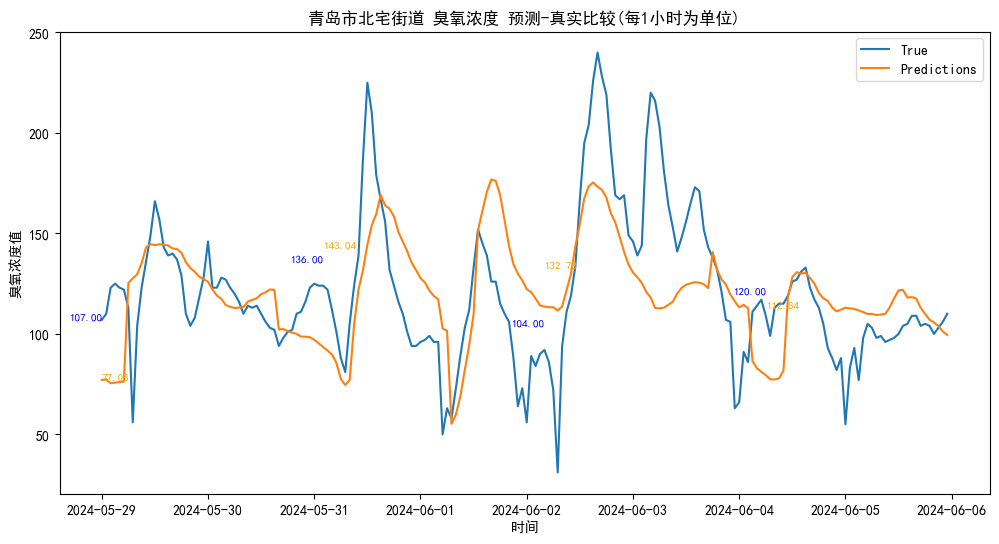

rmse: 32.050641303738736
r2 score: 0.22710671578526442
all
rmse: 32.050641303738736
r2 score: 0.22710671578526442
all-1
rmse: 34.78840159822816
r2 score: 0.21810217539915755
all-2
rmse: 31.318245341076878
r2 score: 0.3230377592783701


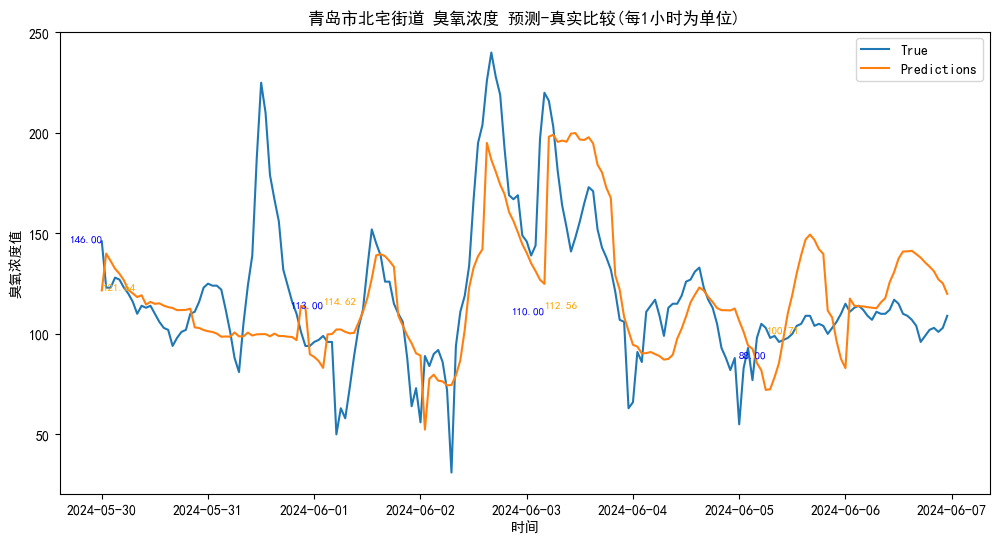

rmse: 29.38185195447813
r2 score: 0.3309367711922151
all
rmse: 29.38185195447813
r2 score: 0.3309367711922151
all-1
rmse: 30.76154805562125
r2 score: 0.39832684374962757
all-2
rmse: 32.68540114745918
r2 score: 0.3934159080837384


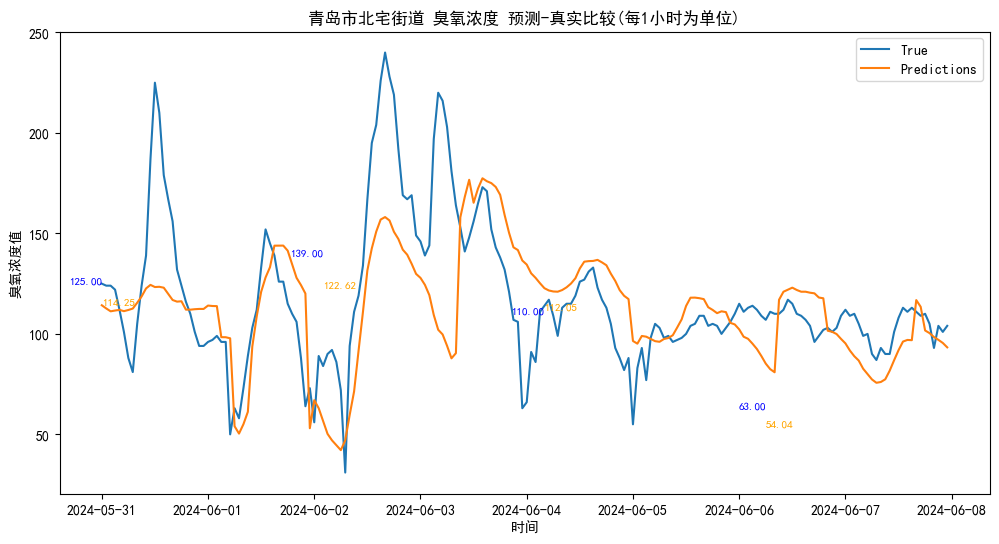

rmse: 31.939424147517858
r2 score: 0.2215658417988362
all
rmse: 31.939424147517858
r2 score: 0.2215658417988362
all-1
rmse: 35.87558894840795
r2 score: 0.2257051219250853
all-2
rmse: 38.90301106785652
r2 score: 0.17494547399228044


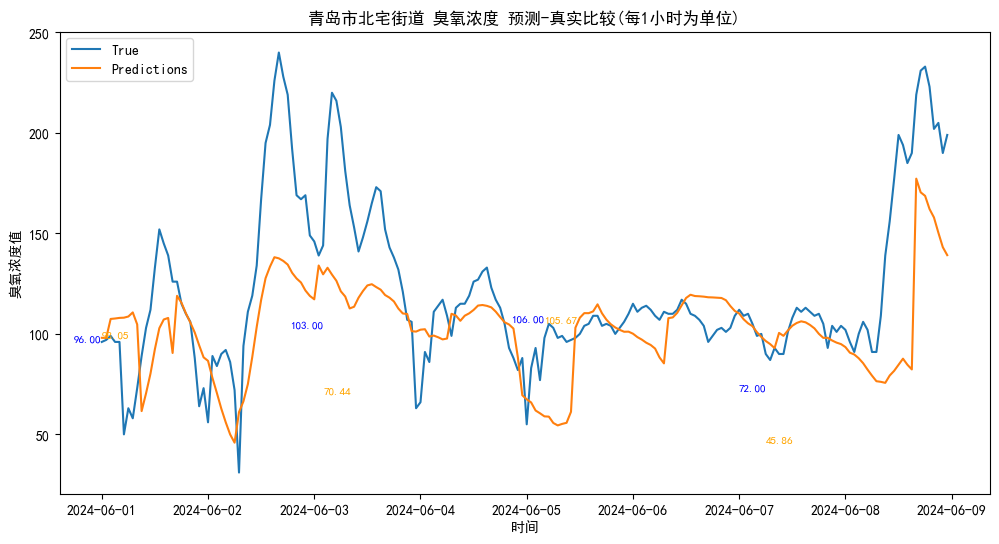

rmse: 36.32637005191726
r2 score: 0.20006838285381567
all
rmse: 36.32637005191726
r2 score: 0.20006838285381567
all-1
rmse: 33.43320783277564
r2 score: 0.2228994544777021
all-2
rmse: 36.071341008139136
r2 score: 0.2333282097620355


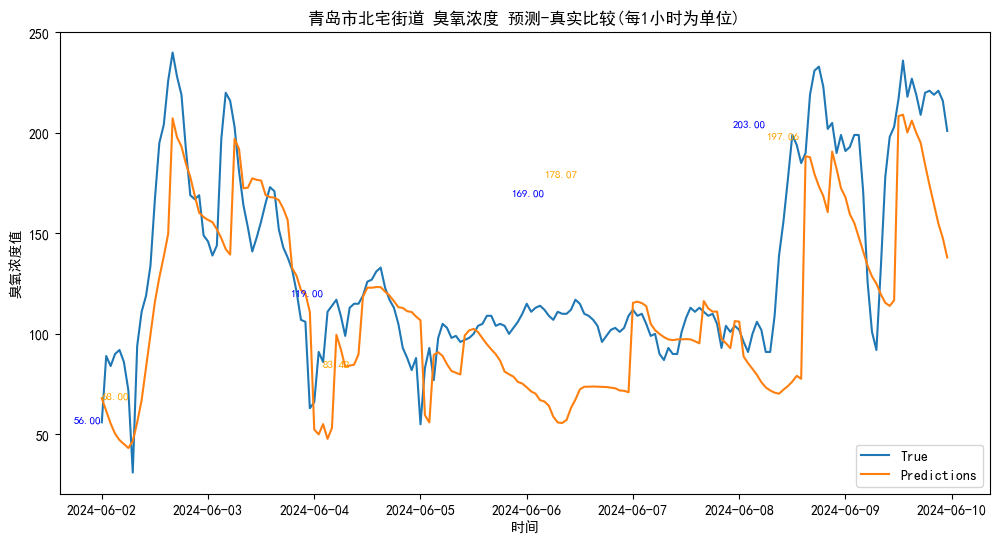

rmse: 36.26114582594611
r2 score: 0.3974345202531263
all
rmse: 36.26114582594611
r2 score: 0.3974345202531263
all-1
rmse: 29.401972281770288
r2 score: 0.3408342799451596
all-2
rmse: 31.98715081107018
r2 score: 0.3183721957887574


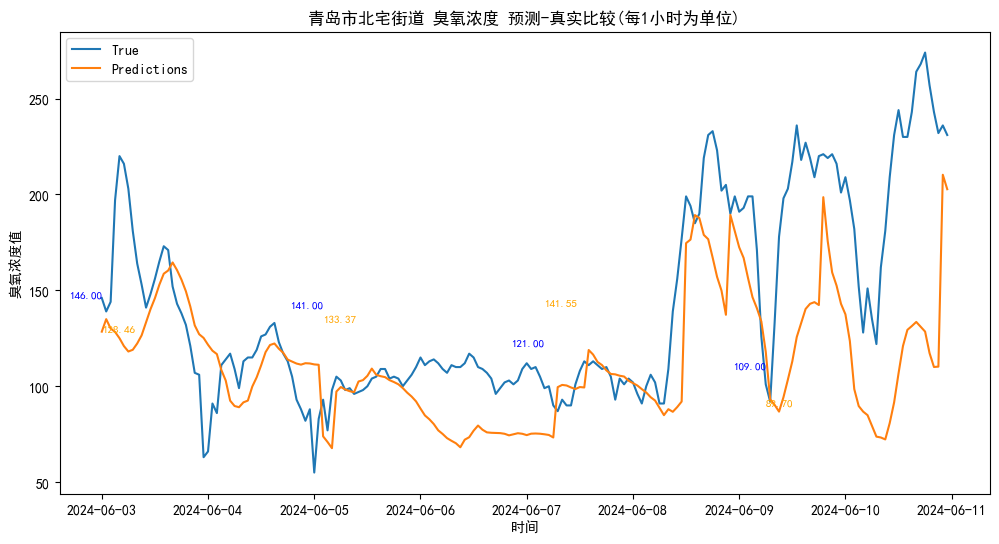

rmse: 50.373199725699756
r2 score: 0.03882790931394975
all
rmse: 50.373199725699756
r2 score: 0.03882790931394975
all-1
rmse: 30.04160974084795
r2 score: 0.33067237050999354
all-2
rmse: 27.828374576637216
r2 score: -0.03796145924094585


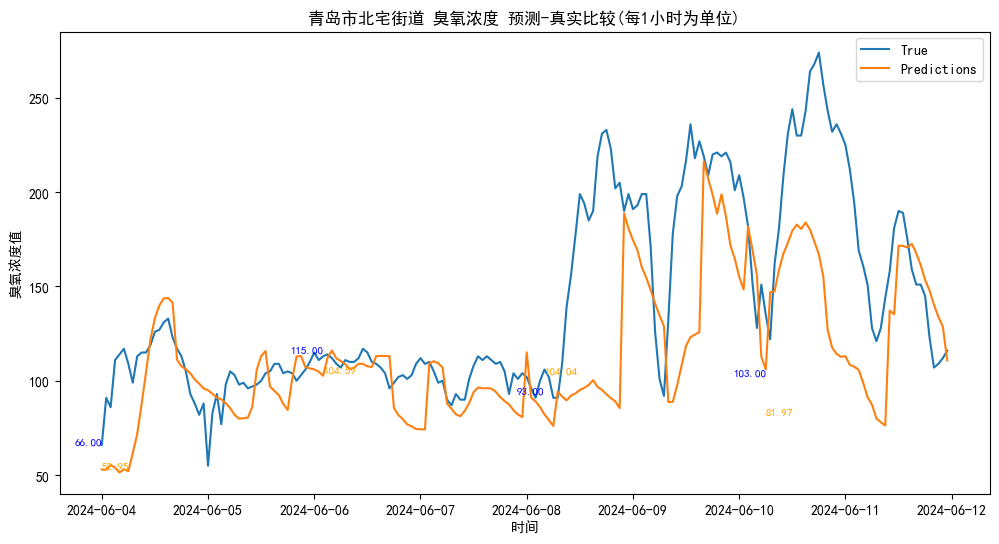

rmse: 48.541890766919614
r2 score: 0.10064909361780183
all
rmse: 48.541890766919614
r2 score: 0.10064909361780183
all-1
rmse: 43.52971899987712
r2 score: 0.05871139284096849
all-2
rmse: 39.647588849433326
r2 score: -0.3875050036757559


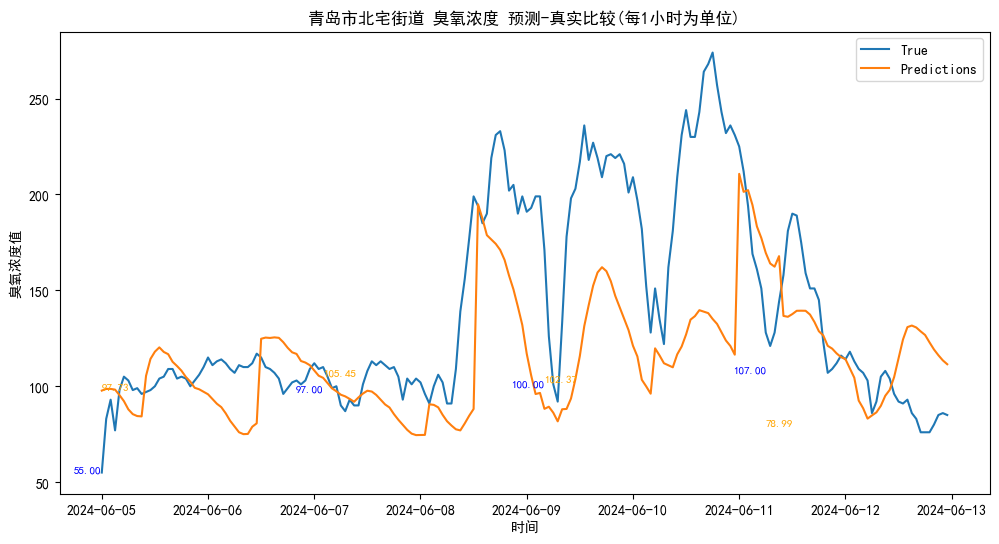

rmse: 49.87695717599767
r2 score: 0.0906029615661832
all
rmse: 49.87695717599767
r2 score: 0.0906029615661832
all-1
rmse: 55.21727107226179
r2 score: -0.0026844181301795
all-2
rmse: 43.23014243003622
r2 score: 0.17196097193027526


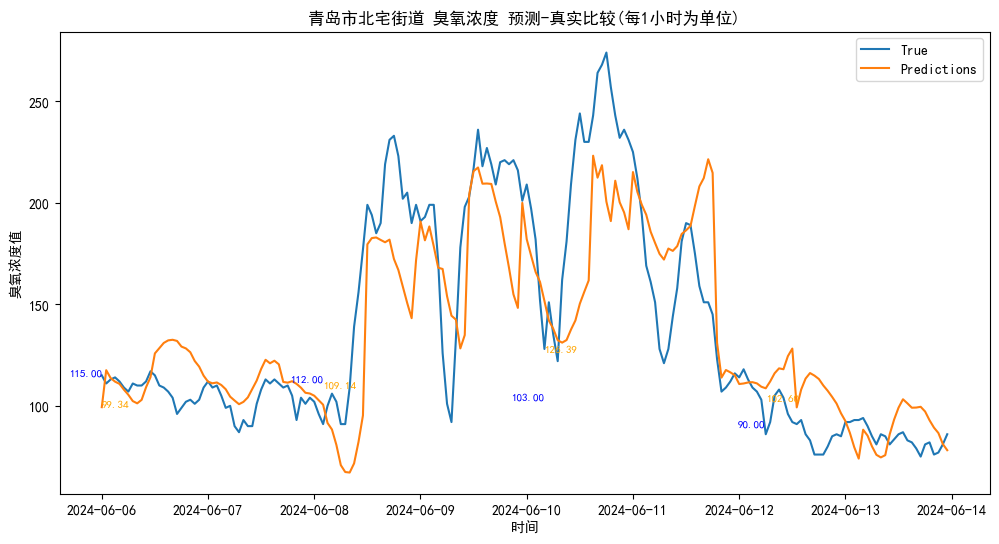

rmse: 30.55831332151287
r2 score: 0.6763603325686427
all
rmse: 30.55831332151287
r2 score: 0.6763603325686427
all-1
rmse: 33.771494088919326
r2 score: 0.5863940885188471
all-2
rmse: 33.72569226434162
r2 score: 0.6331045660363108


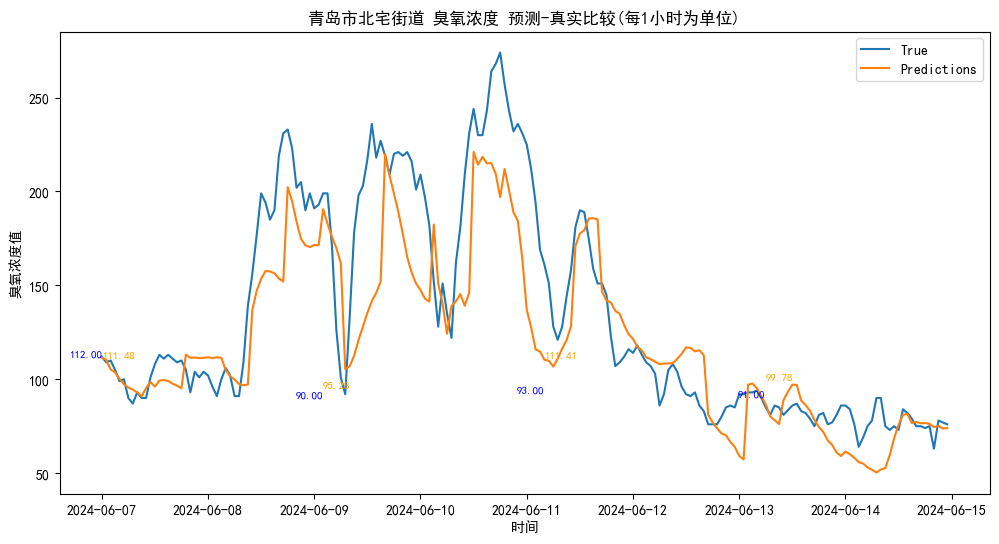

rmse: 31.51623957282706
r2 score: 0.6923396817399847
all
rmse: 31.51623957282706
r2 score: 0.6923396817399847
all-1
rmse: 35.29997818949869
r2 score: 0.5874937433288381
all-2
rmse: 38.02775037071349
r2 score: 0.48278081036316267


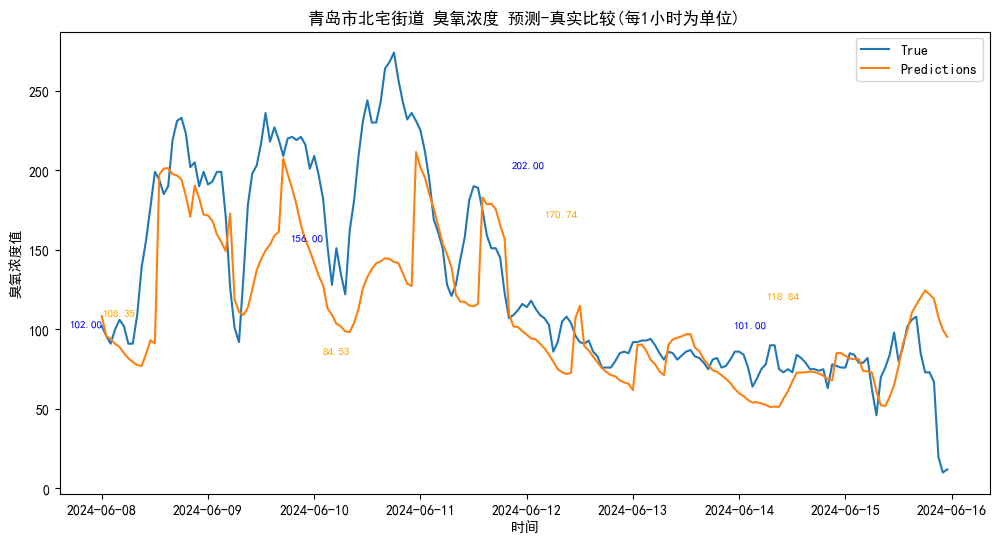

rmse: 42.94417129661184
r2 score: 0.49319185107444063
all
rmse: 42.94417129661184
r2 score: 0.49319185107444063
all-1
rmse: 46.49399475854685
r2 score: 0.35645984007848674
all-2
rmse: 50.670249422435795
r2 score: 0.15339263379932067


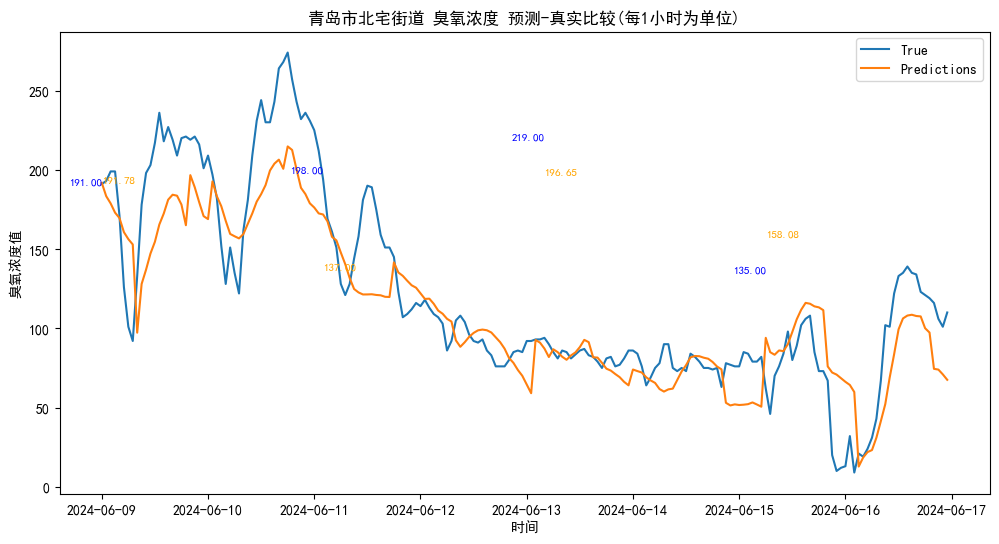

rmse: 29.50841393443846
r2 score: 0.7605729037076054
all
rmse: 29.50841393443846
r2 score: 0.7605729037076054
all-1
rmse: 29.042417894884
r2 score: 0.7645513061801126
all-2
rmse: 31.193980560080345
r2 score: 0.7201317628938145


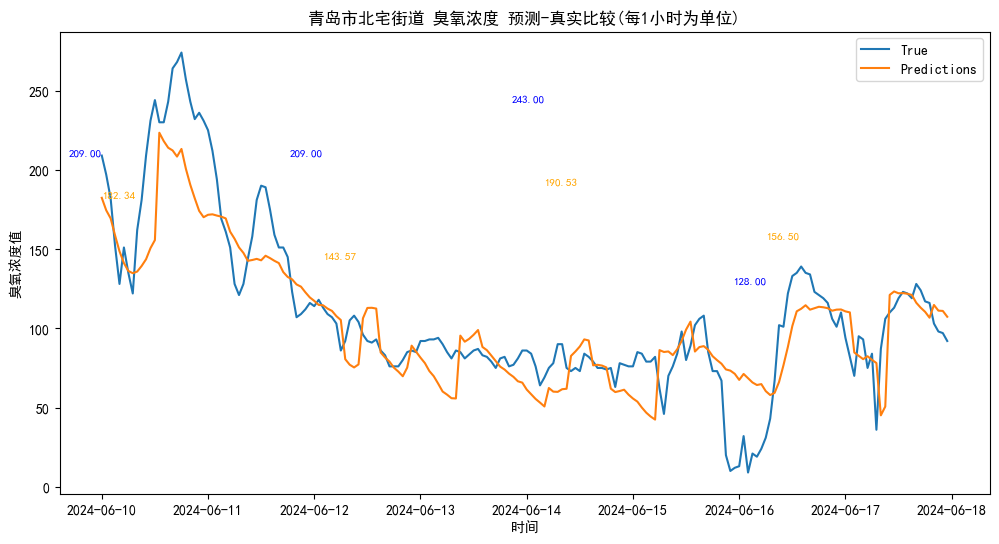

rmse: 26.553973047780524
r2 score: 0.7480034056214029
all
rmse: 26.553973047780524
r2 score: 0.7480034056214029
all-1
rmse: 26.90871630687671
r2 score: 0.7706256678000862
all-2
rmse: 26.332667464105903
r2 score: 0.7846365219980648


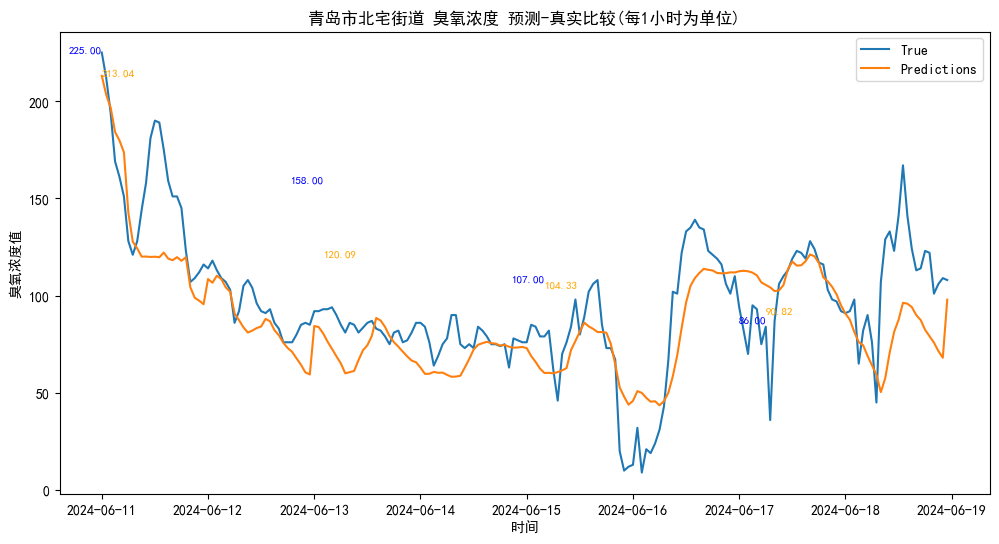

rmse: 23.463641912913953
r2 score: 0.5551846891582903
all
rmse: 23.463641912913953
r2 score: 0.5551846891582903
all-1
rmse: 20.586648608562218
r2 score: 0.7049517395310352
all-2
rmse: 19.73262870218027
r2 score: 0.6942598508980335


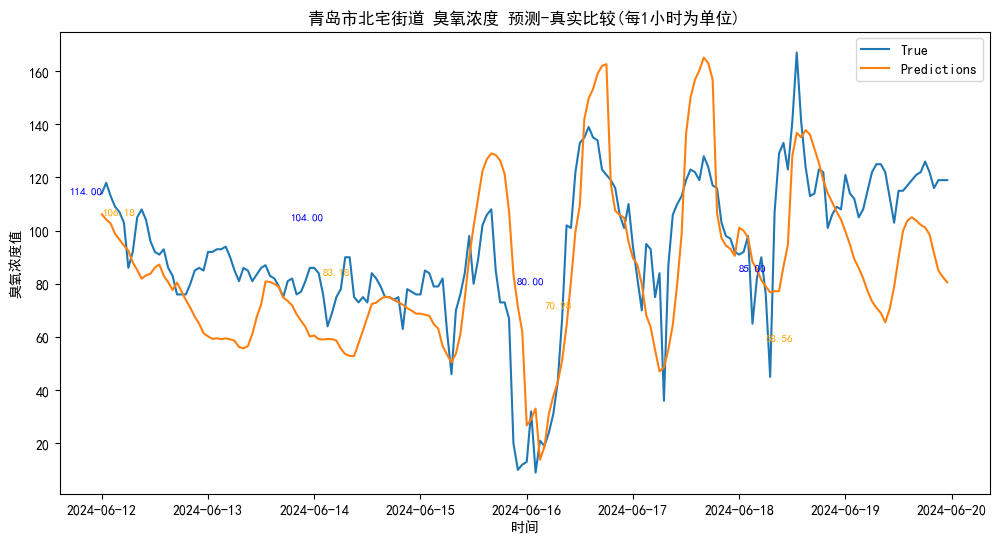

rmse: 23.58437537955888
r2 score: 0.24299026179474625
all
rmse: 23.58437537955888
r2 score: 0.24299026179474625
all-1
rmse: 22.16176153579095
r2 score: 0.26835991078159716
all-2
rmse: 21.34612034852511
r2 score: 0.31813158182902135


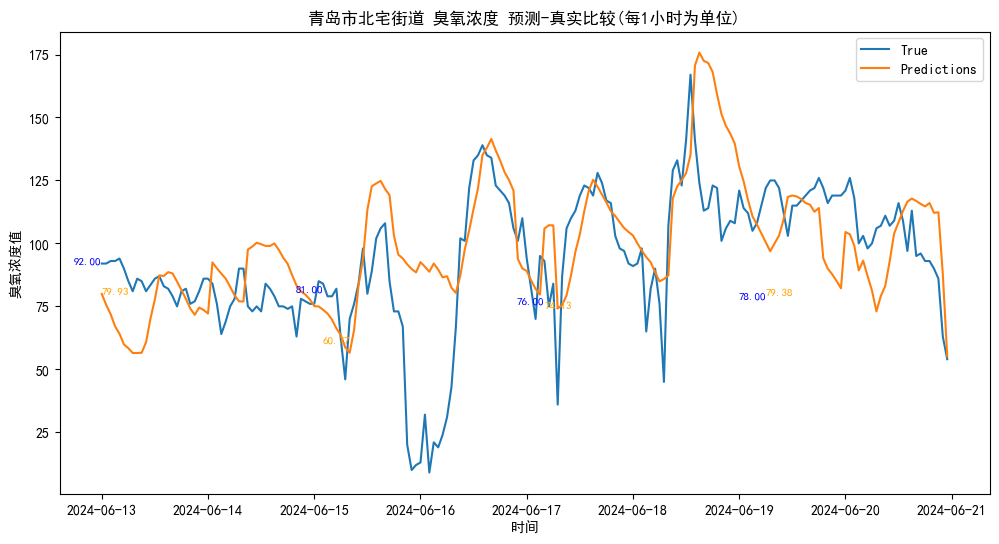

rmse: 25.484596758332632
r2 score: 0.13841458302838727
all
rmse: 25.484596758332632
r2 score: 0.13841458302838727
all-1
rmse: 27.35456460428868
r2 score: 0.09225169367865715
all-2
rmse: 26.264957054700087
r2 score: 0.08673993757072362


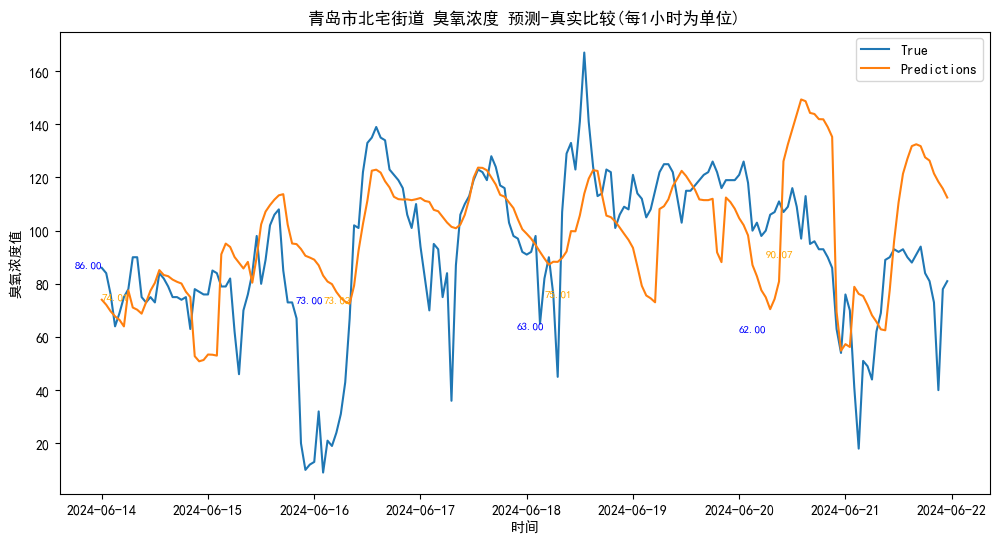

rmse: 27.920380825290113
r2 score: 0.0800325659872625
all
rmse: 27.920380825290113
r2 score: 0.0800325659872625
all-1
rmse: 25.29402988423963
r2 score: 0.31631741987905737
all-2
rmse: 26.193004562484933
r2 score: 0.3002343828186267


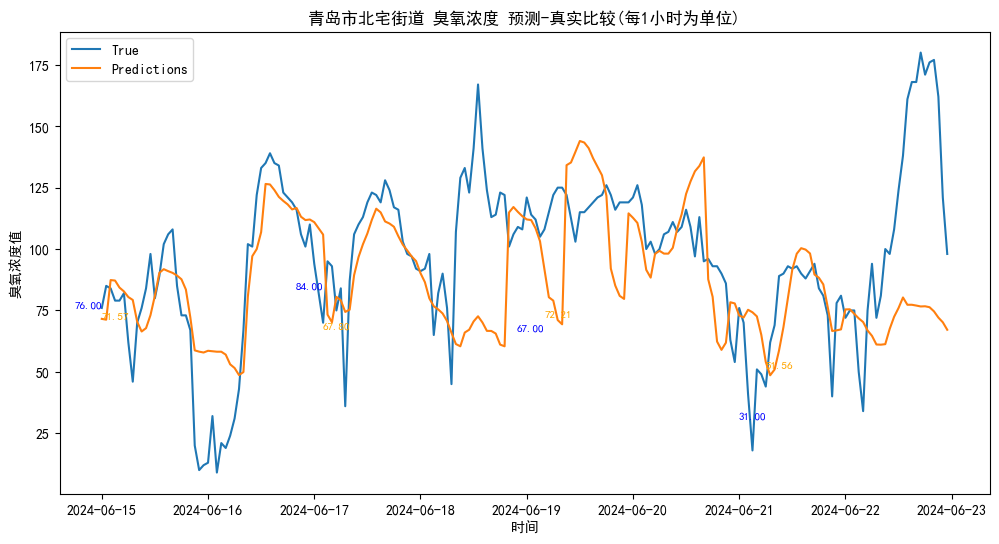

rmse: 32.463829756740196
r2 score: 0.04968487326337501
all
rmse: 32.463829756740196
r2 score: 0.04968487326337501
all-1
rmse: 27.1301702343672
r2 score: 0.19864403812122056
all-2
rmse: 28.51502982058859
r2 score: 0.22426259426496986


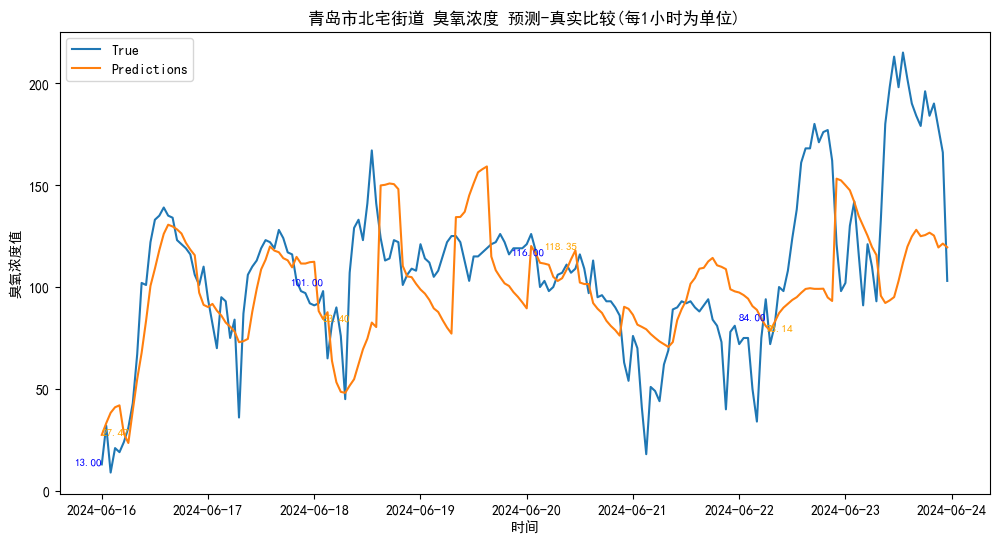

rmse: 35.59939130840905
r2 score: 0.17140947414827223
all
rmse: 35.59939130840905
r2 score: 0.17140947414827223
all-1
rmse: 25.425519459266717
r2 score: 0.26687295175829917
all-2
rmse: 24.98325608427582
r2 score: 0.2398895678837405


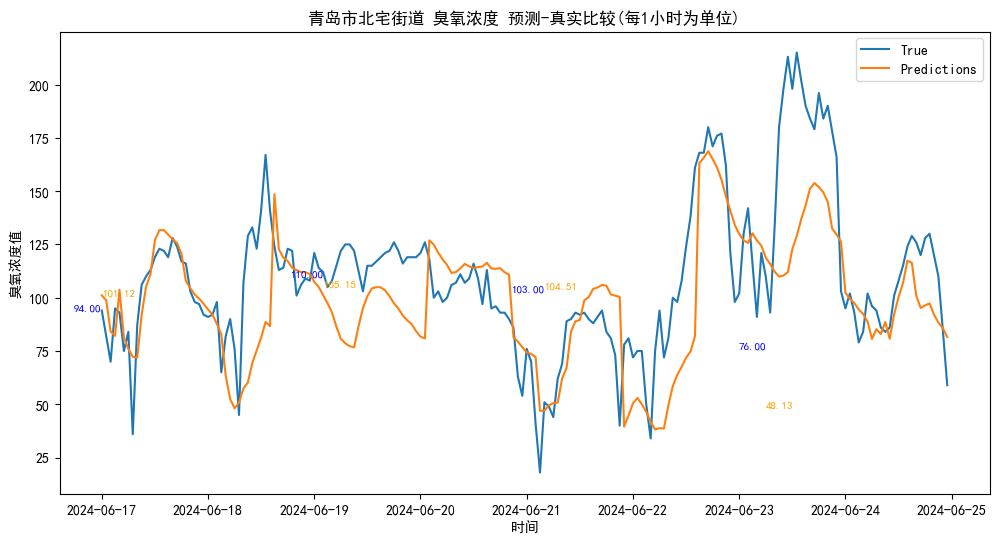

rmse: 29.027637143621817
r2 score: 0.3222747486413281
all
rmse: 29.027637143621817
r2 score: 0.3222747486413281
all-1
rmse: 26.180071502811575
r2 score: 0.20251166073616056
all-2
rmse: 24.196881903454333
r2 score: 0.01572736131947816


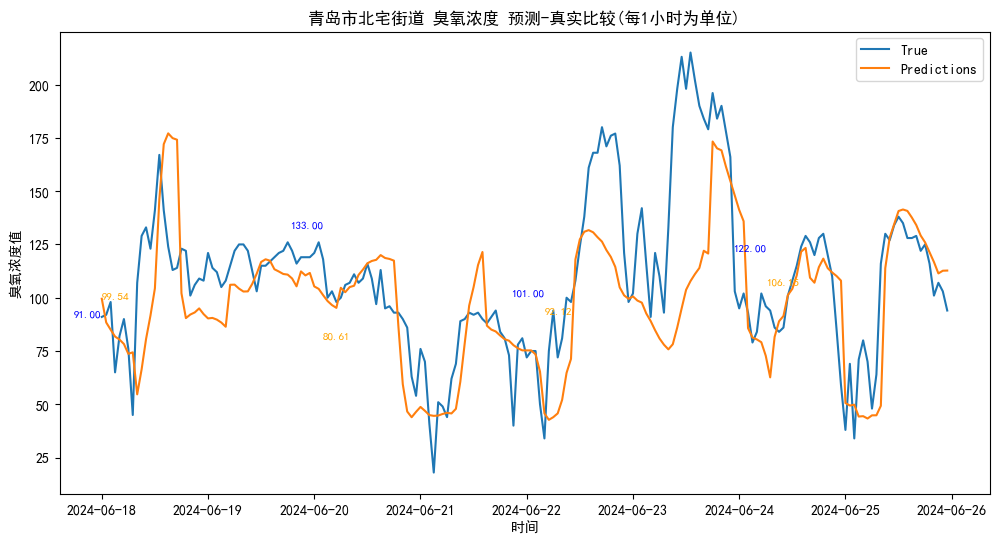

rmse: 30.909958797488162
r2 score: 0.27494694981411183
all
rmse: 30.909958797488162
r2 score: 0.27494694981411183
all-1
rmse: 33.78537825958511
r2 score: 0.23761811350238327
all-2
rmse: 24.68917936506714
r2 score: 0.35326858252261517


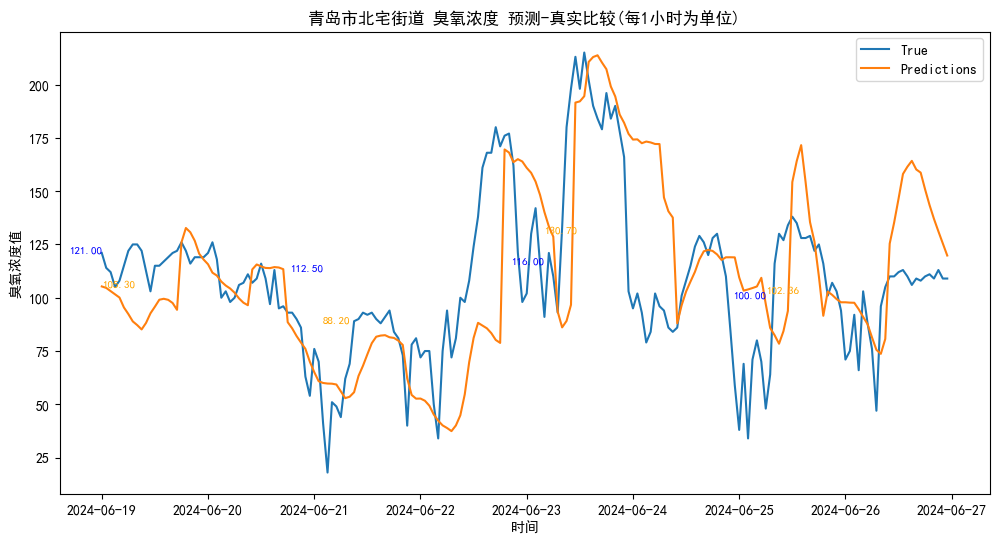

rmse: 34.972184839991414
r2 score: 0.049590636059776094
all
rmse: 34.972184839991414
r2 score: 0.049590636059776094
all-1
rmse: 35.54080250480944
r2 score: 0.13145189927933365
all-2
rmse: 31.961631693586828
r2 score: 0.38382211492782825


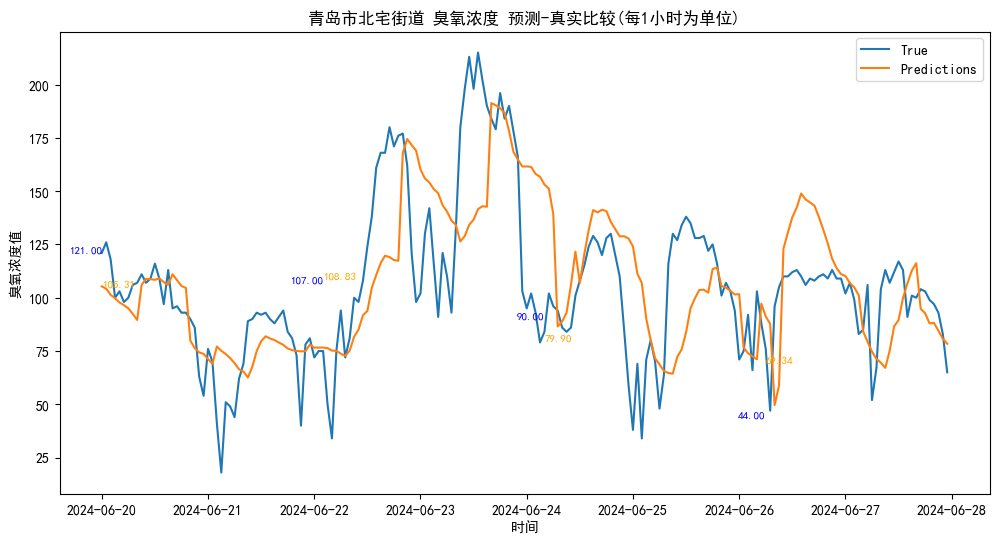

rmse: 31.289071736232213
r2 score: 0.25592623775172463
all
rmse: 31.289071736232213
r2 score: 0.25592623775172463
all-1
rmse: 33.461933219452774
r2 score: 0.31172663465483563
all-2
rmse: 32.33027619290342
r2 score: 0.39555451425526456


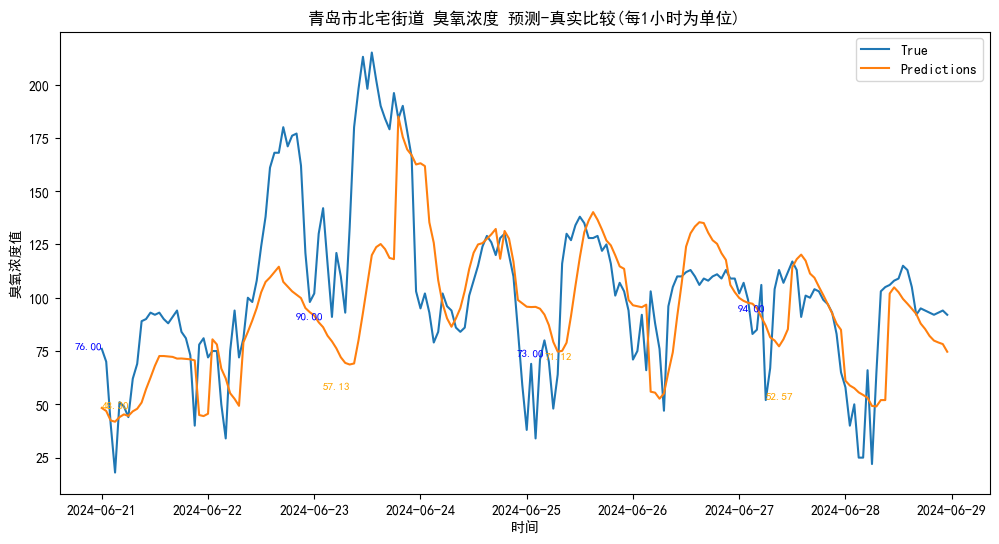

rmse: 33.48407558208898
r2 score: 0.228255594601393
all
rmse: 33.48407558208898
r2 score: 0.228255594601393
all-1
rmse: 37.04491011060289
r2 score: 0.16475817099214163
all-2
rmse: 39.33721625344772
r2 score: 0.1792615729835293


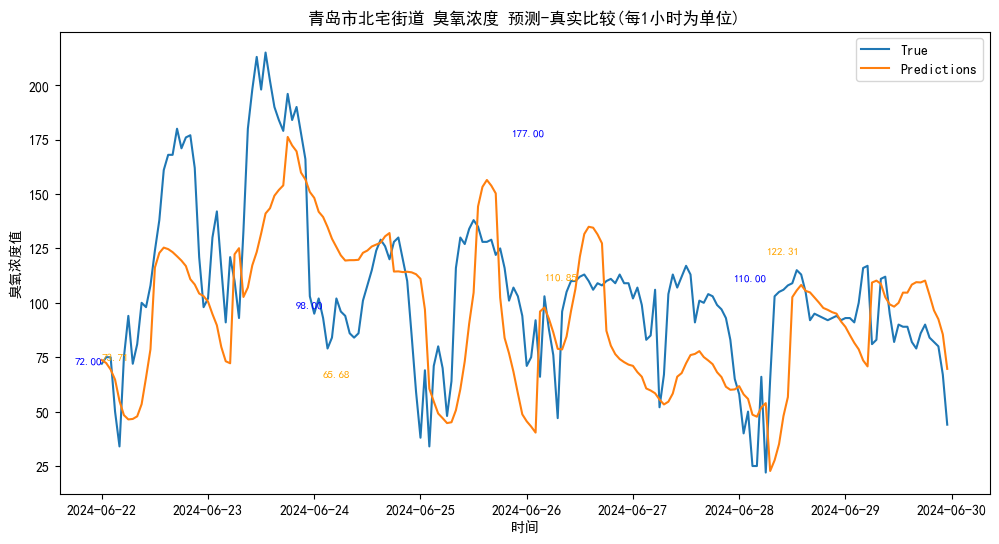

rmse: 33.49408057197703
r2 score: 0.15661980028189781
all
rmse: 33.49408057197703
r2 score: 0.15661980028189781
all-1
rmse: 35.60305905315308
r2 score: 0.10120784298351926
all-2
rmse: 36.076114913329874
r2 score: 0.17640318319460302


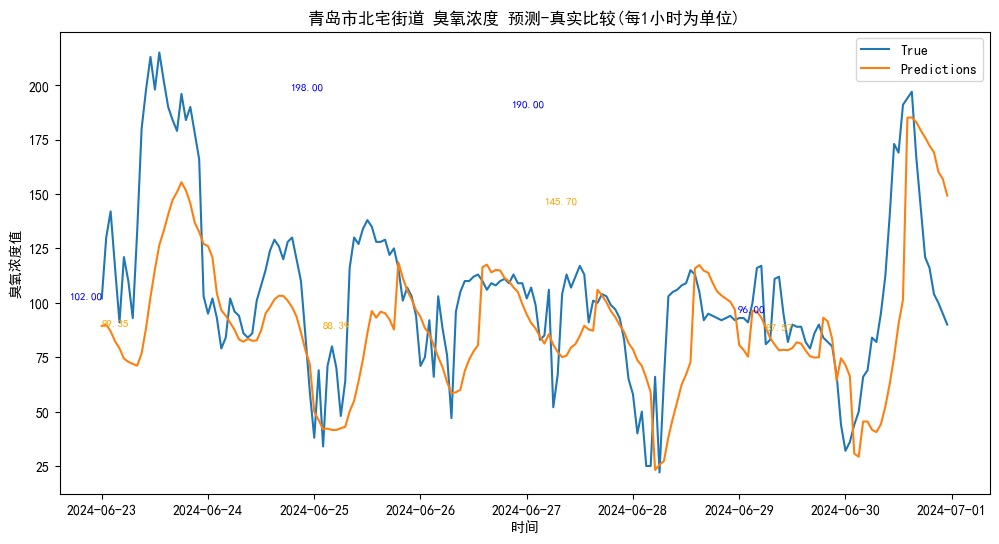

rmse: 35.25244364529609
r2 score: 0.10291168511001536
all
rmse: 35.25244364529609
r2 score: 0.10291168511001536
all-1
rmse: 33.97966036053726
r2 score: 0.14006538686919878
all-2
rmse: 34.24058752230812
r2 score: 0.09481706196568351


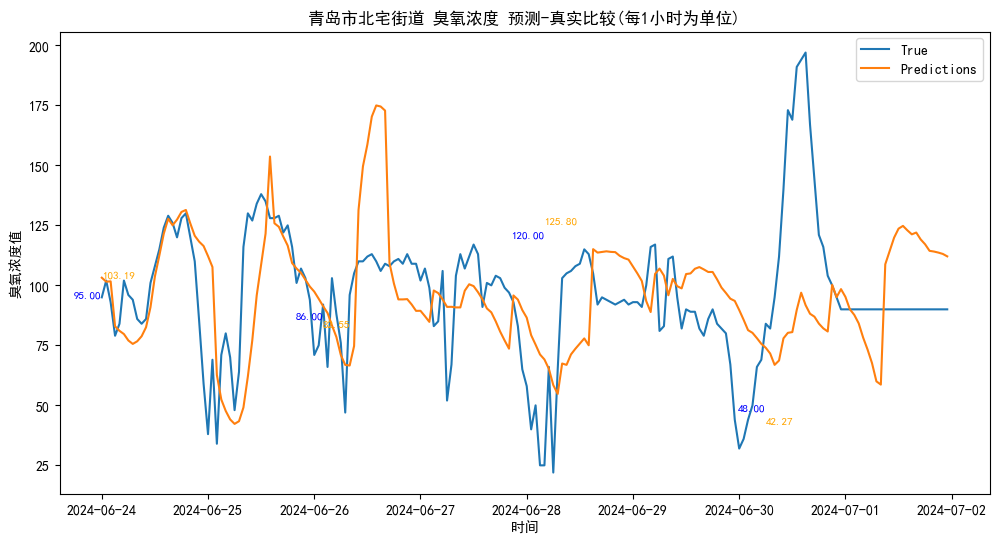

rmse: 31.102399351195967
r2 score: -0.26509793798133896
all
rmse: 31.102399351195967
r2 score: -0.26509793798133896
all-1
rmse: 25.88121387451132
r2 score: -0.19957419384671393
all-2
rmse: 26.825452189924473
r2 score: -0.16978490993225148


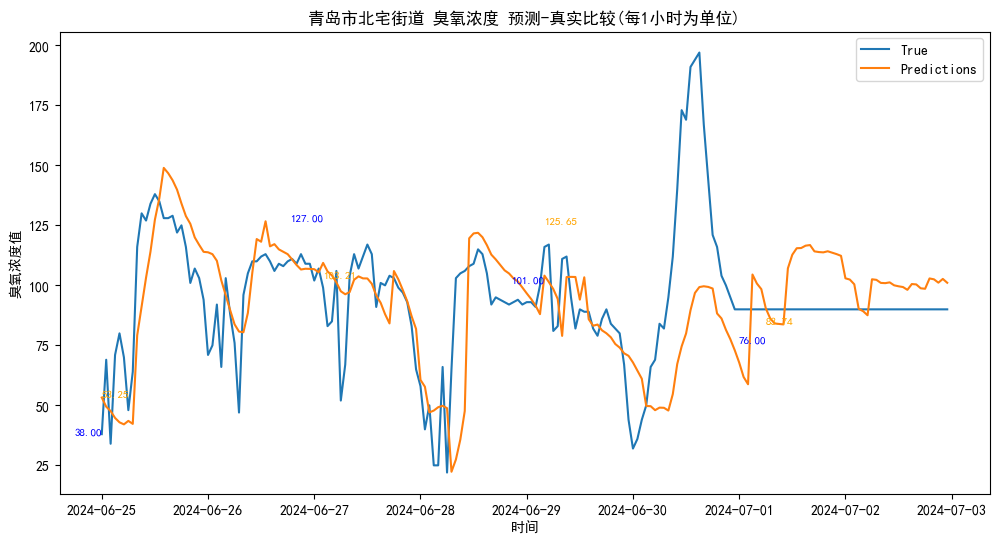

rmse: 26.291063384378326
r2 score: 0.03896674547855017
all
rmse: 26.291063384378326
r2 score: 0.03896674547855017
all-1
rmse: 28.861926635373734
r2 score: 0.12292955541889261
all-2
rmse: 19.95812807767912
r2 score: 0.3215913648089652


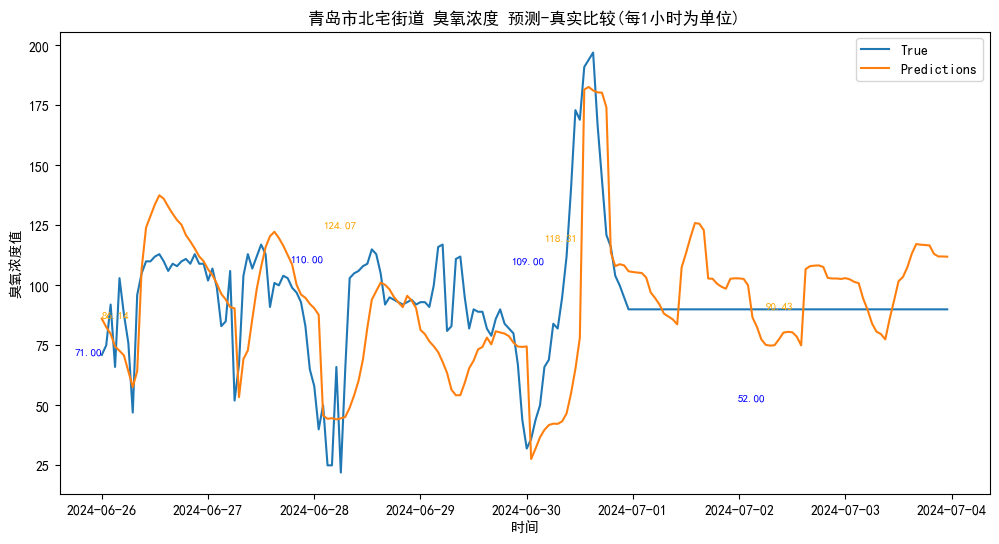

rmse: 24.34559787441969
r2 score: -0.010585804748950434
all
rmse: 24.34559787441969
r2 score: -0.010585804748950434
all-1
rmse: 26.666296588516467
r2 score: 0.08511249241716745
all-2
rmse: 28.13987152717961
r2 score: 0.14682930458705878


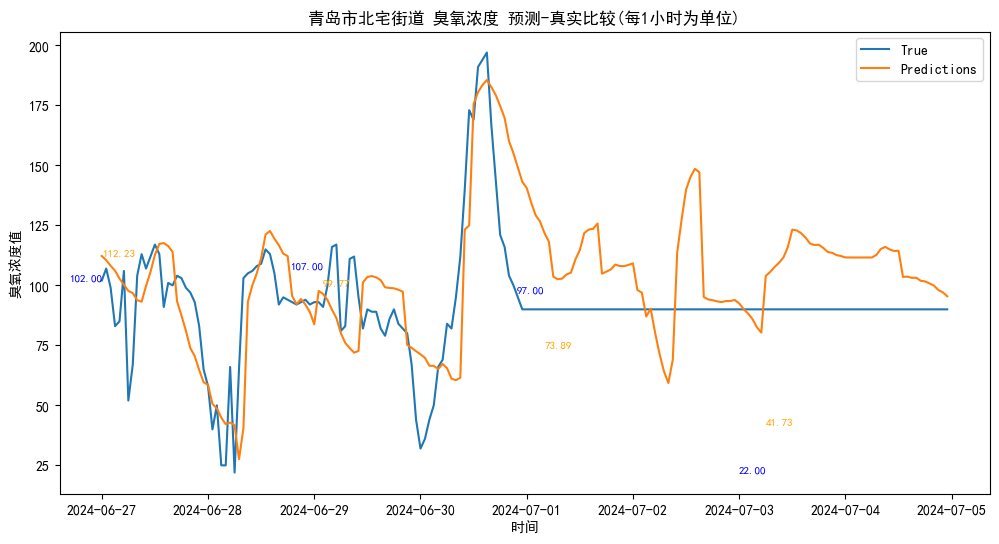

rmse: 23.991541238271267
r2 score: -0.05808764093870855
all
rmse: 23.991541238271267
r2 score: -0.05808764093870855
all-1
rmse: 25.103556507037517
r2 score: 0.12848687831867633
all-2
rmse: 24.740017158639372
r2 score: 0.2928776051811416


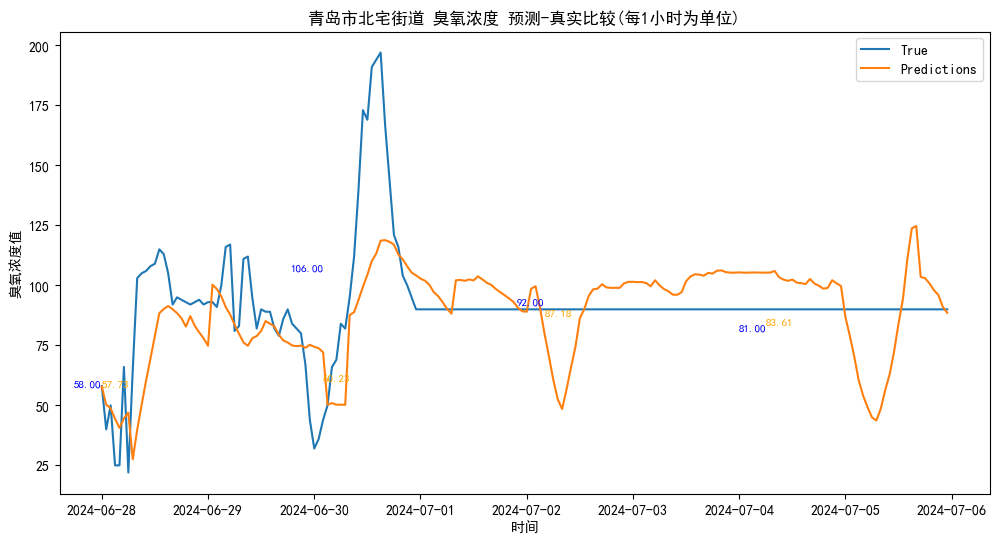

rmse: 22.58218858023429
r2 score: 0.000985516597959979
all
rmse: 22.58218858023429
r2 score: 0.000985516597959979
all-1
rmse: 23.28742753382363
r2 score: 0.20204545010008113
all-2
rmse: 24.892968418431494
r2 score: 0.23929682742697778


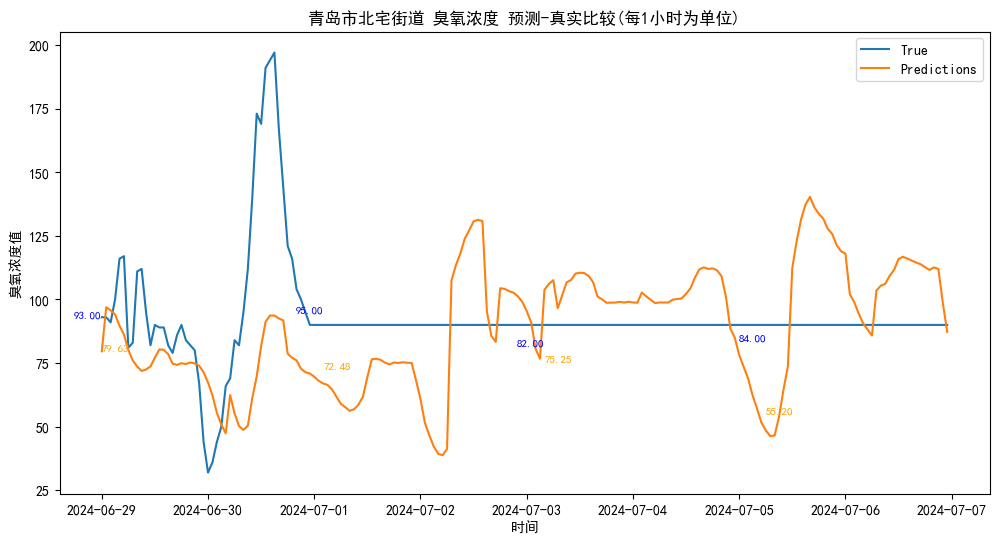

rmse: 29.87018987006976
r2 score: -1.284051165844947
all
rmse: 29.87018987006976
r2 score: -1.284051165844947
all-1
rmse: 30.33793747723813
r2 score: -0.7768633488807266
all-2
rmse: 32.626230291510886
r2 score: -0.7201116432997856


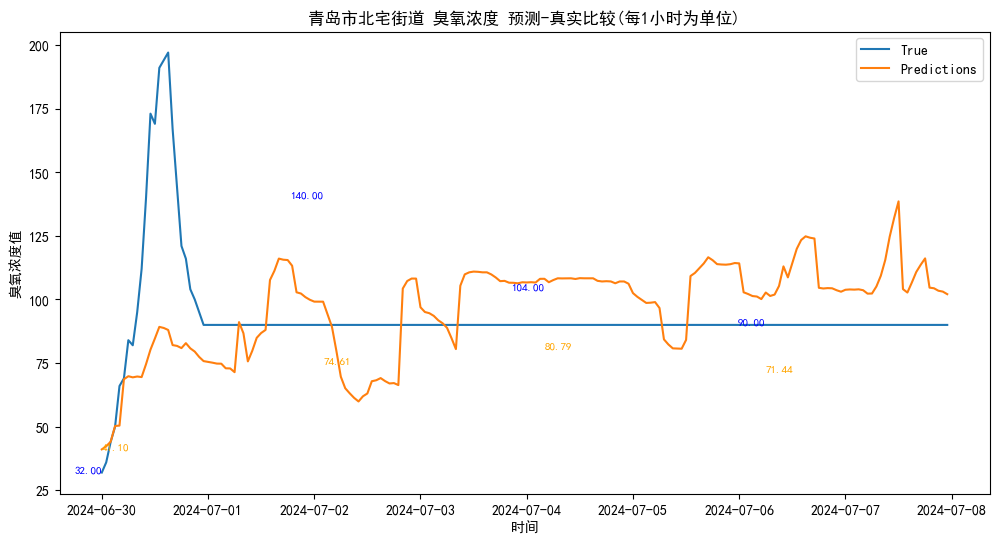

rmse: 25.906189700485225
r2 score: -0.8631468218362195
all
rmse: 25.906189700485225
r2 score: -0.8631468218362195
all-1
rmse: 27.34500552498174
r2 score: -0.5671601033501479
all-2
rmse: 28.949846557783506
r2 score: -0.4715230982368521


In [16]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
for i in range(len(df_list)):
# 绘制真实值和预测值的曲线
    plt.figure(figsize=(12, 6))
    plt.title("青岛市北宅街道 臭氧浓度 预测-真实比较(每1小时为单位)")
    plt.plot(df_list[i]['日期'],y_list[i].values , label='True')
    plt.plot(df_list[i]['日期'],y_pred_list[i] , label='Predictions')
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

# 显示每个具体的数值
    for j in range(0, len(df_list[i]), 10):
        if 5 * j < len(df_list[i]):
            plt.text(df_list[i].iloc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
            plt.text(df_list[i].iloc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')
    plt.legend()
    plt.show()
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
    print("all")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
    print("all-1")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values[:-(2*24)], y_pred_list[i][:-(2*24)])))
    print("r2 score:", r2_score(y_list[i].values[:-(2*24)], y_pred_list[i][:-(2*24)]))
    print("all-2")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values[:-(3 *24)], y_pred_list[i][:-(3 *24)])))
    print("r2 score:", r2_score(y_list[i].values[:-(3 *24)], y_pred_list[i][:-(3 *24)]))

KeyError: 0

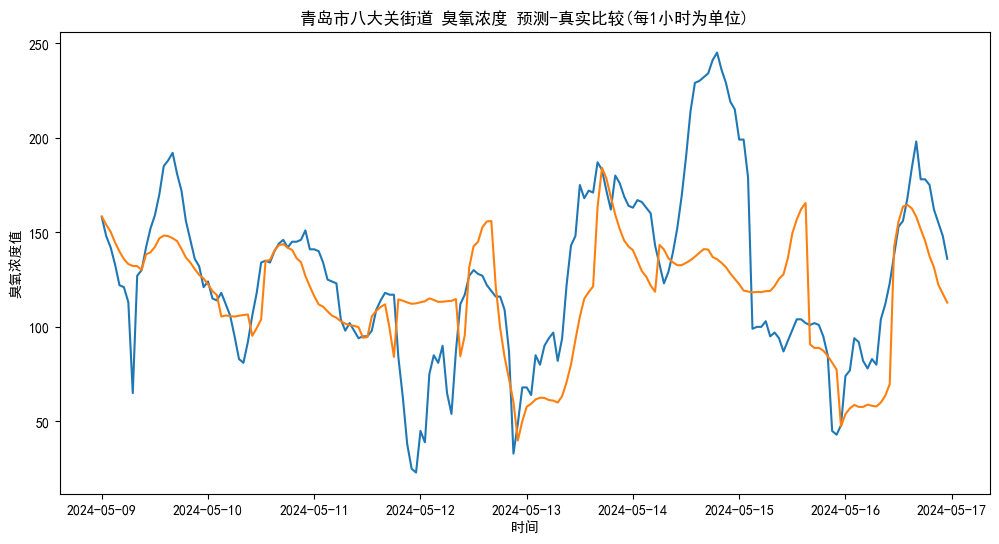

In [17]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
for i in range(len(df_list)):
# 绘制真实值和预测值的曲线
    plt.figure(figsize=(12, 6))
    plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")
    plt.plot(df_list[i]['日期'],y_list[i].values , label='True')
    plt.plot(df_list[i]['日期'],y_pred_list[i] , label='Predictions')
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

# 显示每个具体的数值
    for j in range(0, len(df_list[i]), 10):
        plt.text(df_list[i].loc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
        plt.text(df_list[i].loc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')
    plt.legend()
    plt.show()
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math


for i in range(len(df_list)):
    # 将每小时的数据转换为最大滑动八小时的数据
    max_rolling_8h = y_list[i].rolling(window=8, min_periods=1).max().dropna()

    # 获取对应的时间戳
    rolling_8h_timestamps = df_list[i]['日期'].iloc[7::8]

    # 确保预测值列表的长度能够被8整除
    remainder = len(y_pred_list[i]) % 8
    if remainder != 0:
        # 如果不整除，去除多余的预测值
        y_pred_list[i] = y_pred_list[i][:-remainder]

    # 对预测值也做类似的处理
    max_rolling_8h_pred = [np.max(y_pred_list[i][j:j+8]) for j in range(0, len(y_pred_list[i]), 8)]
    
    # 确保预测值列表与真实值列表长度相同
    if len(max_rolling_8h) != len(max_rolling_8h_pred):
        # 如果长度不一致，则截断最后一个周期的预测值
        max_rolling_8h_pred = max_rolling_8h_pred[:-1]
    
    # 确保长度一致
    assert len(max_rolling_8h) == len(max_rolling_8h_pred), "Length of max_rolling_8h and max_rolling_8h_pred must be the same"

    plt.figure(figsize=(12, 6))
    plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(最大滑动八小时为单位)")
    
    # 使用每八小时的最大值绘制真实值曲线
    plt.plot(rolling_8h_timestamps, max_rolling_8h.values, label='True Max Rolling 8H')
    
    # 绘制预测值曲线
    plt.plot(rolling_8h_timestamps, max_rolling_8h_pred, label='Predicted Max Rolling 8H')
    
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

    # 显示每个具体的数值
    for j in range(len(max_rolling_8h)):
        plt.text(rolling_8h_timestamps.iloc[j], max_rolling_8h.values[j], f'{max_rolling_8h.values[j]:.2f}', color='blue', fontsize=8, ha='right')
        plt.text(rolling_8h_timestamps.iloc[j], max_rolling_8h_pred[j], f'{max_rolling_8h_pred[j]:.2f}', color='orange', fontsize=8, ha='left')

    plt.legend()
    plt.show()

    # 计算评估指标
    rmse = math.sqrt(mean_squared_error(max_rolling_8h.values, max_rolling_8h_pred))
    r2 = r2_score(max_rolling_8h.values, max_rolling_8h_pred)

    print("rmse:", rmse)
    print("r2 score:", r2)

AssertionError: Length of max_rolling_8h and max_rolling_8h_pred must be the same

In [ ]:
# from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
# import matplotlib.dates as mdates
# from datetime import datetime, timedelta
# date_range_list = []

# start_date = datetime(2024, 5, 9, 0, 0, 0) 
# end_date = datetime(2024, 5, 12, 23, 0, 0)
# while start_date <= datetime(2024, 7, 1, 0, 0, 0):
#     date_range = pd.date_range(start=start_date, end=end_date, freq='H')
#     date_range_list.append(date_range)
#     end_date += timedelta(hours=1)
#     start_date = end_date
#     end_date += timedelta(days=4)
#     end_date -= timedelta(hours=1)
    
# for date_ranges in date_range_list:
#     for i in range(len(df_list)):
#         for index, row in df_list[i].iterrows():
#             if row['日期'] in date_ranges:
#                 plt.figure(figsize=(12, 6))
#                 plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")
#                 plt.plot(row['日期'],y_list[i].values[int(index/5)], label='True')
#                 plt.plot(row['日期'],y_pred_list[i][int(index/5)], label='Predictions')
#                 plt.xlabel('时间')
#                 plt.ylabel('臭氧浓度值')
                


#     # 显示每个具体的数值
#         # for j in range(0, len(df_list[i]), 10):
#         #     plt.text(df_list[i].loc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
#         #     plt.text(df_list[i].loc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')

#         print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
#         print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
#         # sum += 1
#         # if sum >= 1:
#         #     plt.show()
#         #     sum = 0
#         #     plt.figure(figsize=(12, 6))
#         #     plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")

#     plt.show()








